# Transformer 模型结构

In [3]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import math
from collections import defaultdict
from torch.utils.data.dataloader import default_collate
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import copy

# 整体结构

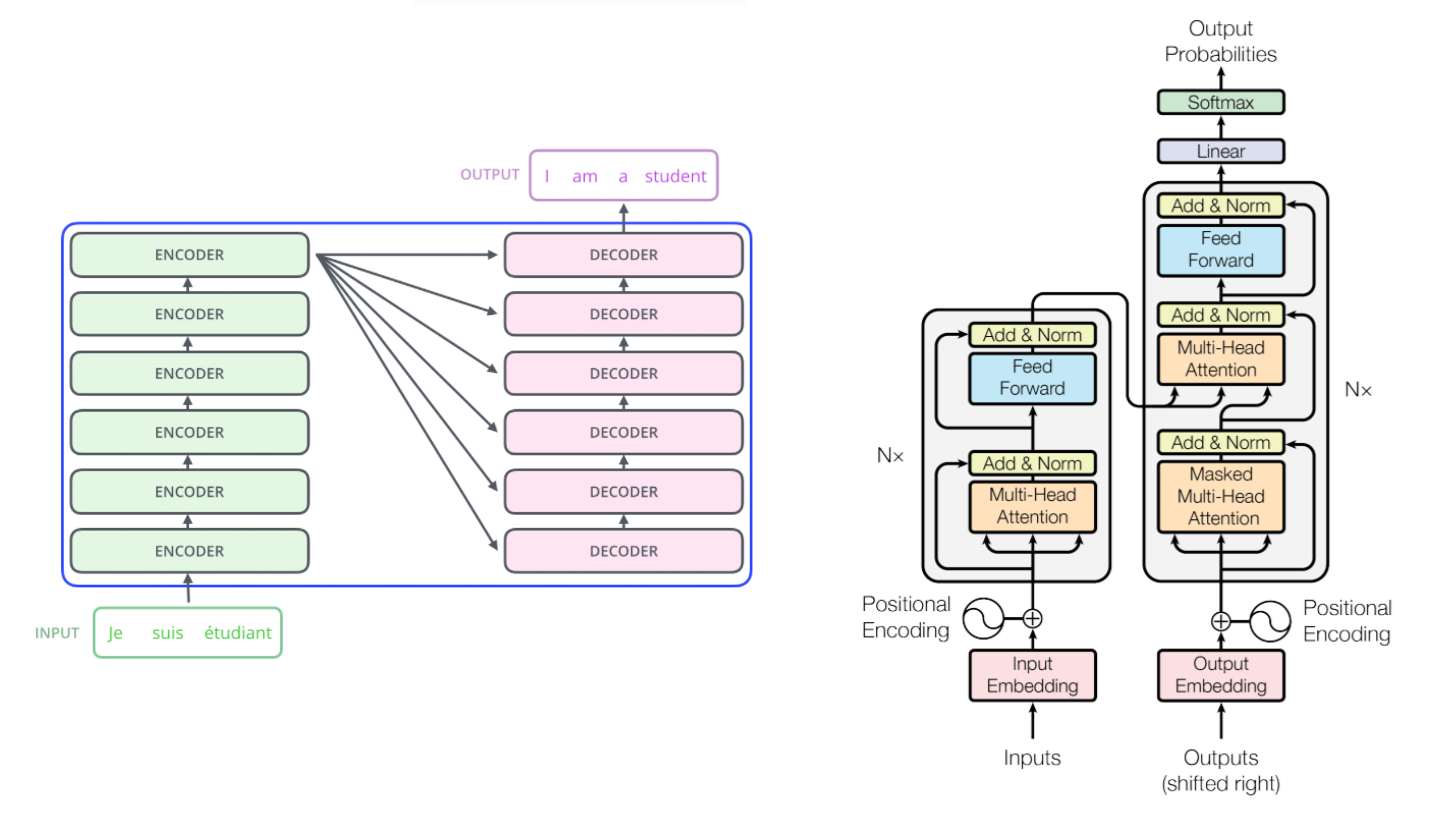

- 通过数据在模型中流动的过程，来分块构造整个 Transformer 模型

# 构建数据集

- 这里先构建一个非常小的数据集，作为 toy example，通过这个小的数据集来作为例子，来展示具体的训练过程
- 数据集为 德语-英文 的机器翻译数据集
- 数据集内包含
    - 训练语料
    - 源端、目标端词表

In [4]:
class ToyExampleMT:

    def __init__(self):
        # 训练语料
        self.train_set = [
            ['ich mochte ein bier', 'i want a beer'],
            ['ich mag apple', 'i like apple']
         ]
        # 源端词表
        self.src_vocab = {
            '[Pad]': 0,
            'ich': 1,
            'mochte': 2,
            'ein': 3,
            'bier': 4,
            'mag': 5,
            'apple': 6,
        }
        self.src_vocab_size = len(self.src_vocab)
        # 目标端词表
        self.trg_vocab = {
            '[Pad]': 0,
            'i': 1,
            'want': 2,
            'a': 3,
            'beer': 4,
            'like': 5,
            'apple': 6,
            '[S]': 7,
            '[E]': 8
        }
        self.trg_vocab_size = len(self.trg_vocab)

In [5]:
data = ToyExampleMT()
print(data.train_set)
print(data.src_vocab)
print(data.trg_vocab)

[['ich mochte ein bier', 'i want a beer'], ['ich mag apple', 'i like apple']]
{'[Pad]': 0, 'ich': 1, 'mochte': 2, 'ein': 3, 'bier': 4, 'mag': 5, 'apple': 6}
{'[Pad]': 0, 'i': 1, 'want': 2, 'a': 3, 'beer': 4, 'like': 5, 'apple': 6, '[S]': 7, '[E]': 8}


- 把数据集内的内容打印出来看一下
- 我们可以看到，数据集中一共只包含了两个 德语-英语（源端-目标端） 句对
- 其中，源端目标端各包含6个不同的词语，再加上\[pad\]（源端、目标端），\[S\]、\[E\]（目标端）这三个特殊字符（作用在后面会讲到）
- 源端词表大小为7，目标端此表大小为9

# 加载数据

- 手动加载数据的方式，在数据量小的时候，并没有太大问题
- 但是到了大数据量，需要打乱训练数据（shuffle），将数据分批（mini-batch）进行训练等操作，手动加载数据的方式就很麻烦了
- 在 pytorch 中，一般会用到 Dataset 和 DataLoader 来加载数据

- Dataset是一个包装类，用来将数据包装为Dataset类，然后传入DataLoader中
- 在做不同任务时，我们一般需要定义一个自己的 Dataset（继承 pytorch 的 Dataset 类），来读取专门的数据
- 在 Dataset 中，我们需要定义
    - **\_\_init\_\_()** 函数，来定义 Dataset 中包含哪些信息
    - **\_\_len\_\_()** 函数，来获取 Dataset 的大小
    - **\_\_getitem\_\_()** 函数，来通过索引获取 Dataset 中的每条数据

In [6]:
class Dataset(torch.utils.data.Dataset):

    def __init__(self, data):
        self.data = self.read_data(data)
        self.src_vocab = data.src_vocab
        self.trg_vocab = data.trg_vocab
        self.src_vocab_size = data.src_vocab_size
        self.trg_vocab_size = data.trg_vocab_size
        self.pad_id = self.src_vocab['[Pad]']

    def read_data(self, data):
        data_to_model = defaultdict(list)
        # tokenize 将训练集中的单词转化为词表中的 id
        for i in range(len(data.train_set)):
            data_to_model['input_ids'].append([data.src_vocab[word] for word in data.train_set[i][0].split()])
            data_to_model['output_ids'].append([data.trg_vocab[word] for word in data.train_set[i][1].split()])
            data_to_model['trg_ids'].append([data.trg_vocab[word] for word in data.train_set[i][1].split()])
        # 加上开头结尾的特殊字符
        for i in range(len(data.train_set)):
            data_to_model['output_ids'][i].insert(0, 7)
            data_to_model['trg_ids'][i].append(8)

        return data_to_model

    # 通过下标得到某一个样本
    # 这里的 __getitem__ 函数用于 dataloader 中取 batch 送入模型训练
    # 所以要把数据类型转为 torch.LongTensor
    def __getitem__(self, id):
        item = {}
        item['input_ids'] = torch.LongTensor(self.data['input_ids'][id])
        item['output_ids'] = torch.LongTensor(self.data['output_ids'][id])
        item['trg_ids'] = torch.LongTensor(self.data['trg_ids'][id])
        return item

    # 数据大小
    def __len__(self):
        return len(self.data['input_ids'])

In [7]:
train_dataset = Dataset(data)
print("\n------------data------------")
print(train_dataset.data)
print("\n------------data size------------")
print(train_dataset.__len__())
print("\n------------first training data------------")
print(train_dataset.__getitem__(0))


------------data------------
defaultdict(<class 'list'>, {'input_ids': [[1, 2, 3, 4], [1, 5, 6]], 'output_ids': [[7, 1, 2, 3, 4], [7, 1, 5, 6]], 'trg_ids': [[1, 2, 3, 4, 8], [1, 5, 6, 8]]})

------------data size------------
2

------------first training data------------
{'input_ids': tensor([1, 2, 3, 4]), 'output_ids': tensor([7, 1, 2, 3, 4]), 'trg_ids': tensor([1, 2, 3, 4, 8])}


- 我们来看一下 Dataset 类的效果
- 我们可以看到，每条训练数据，被构造为了3个序列
    - input_ids
    - output_ids
    - trg_ids
- 这三条数据分别对应下面三个部分

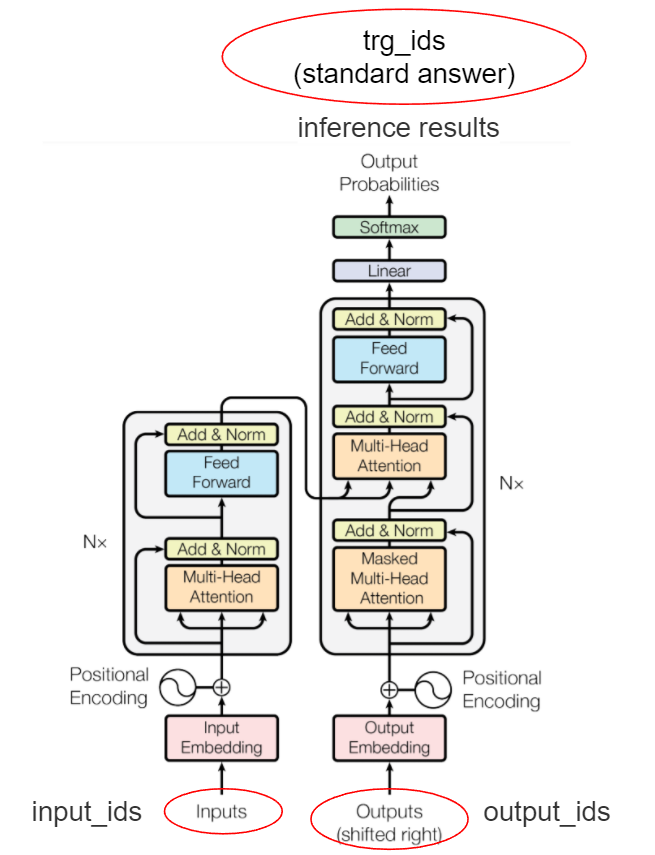

- input_ids 是源端句子中每个词语转化成字典中id的序列
    - 'ich mochte ein bier'  —— \[1, 2, 3, 4\]
    - 这个序列就是训练数据的源端输入序列

- output_ids 是目标端句子中每个词语转化成字典中id的序列，但是只加上开头特殊符号\[S\]
    - 'i want a beer ' —— '\[S\] i want a beer ' —— \[7, 1, 2, 3, 4\]
    - 这个序列就是训练数据中的目标端输入序列

- trg_ids 是目标端句子中每个词语转化成字典中id的序列，但是只加上结尾特殊符号\[E\]
    - 'i want a beer ' —— 'i want a beer \[E\]' —— \[1, 2, 3, 4, 8\]
    - 这个序列就是训练数据中的标准答案
    - 每一条训练数据预测出来的结果和这个序列计算损失，进行反向传播

- 在把数据从 Dataset 传入 Dataloader 之前，要知道一件事，每一批（batch）数据中的句子长度是有差异的
- PyTorch 中的 DataLoader 为了并行计算，要求 batch 内的矩阵必须有相同的 size
- 所以需要实现一个函数，在调用 DataLoader 时，来对每个 batch 的数据进行填充（padding）

In [8]:
# 在每个 batch 里把数据的长度 padding 成一样的(按照这个 batch 最长的句子)
# PyTorch 中的 DataLoader 为了并行计算，要求 batch 内的矩阵必须有相同的 size
# 不同的 batch 之间并不一定是相同的 size
class Padding_in_batch:
    def __init__(self, pad_id):
        self.pad_id = pad_id

    def pad(self, seq, pad_id, max_len):
        pad_part = torch.LongTensor([pad_id] * (max_len - seq.shape[-1]))
        pad_seq = torch.cat([seq, pad_part], dim=-1)
        return pad_seq

    def __call__(self, batch):
        input_max_len = 0
        output_max_len = 0
        for item in batch:
            input_max_len = max(input_max_len, len(item["input_ids"]))
            output_max_len = max(output_max_len, len(item["output_ids"]))

        for item in batch:
            item['input_ids'] = self.pad(item['input_ids'], self.pad_id, input_max_len)
            item['output_ids'] = self.pad(item['output_ids'], self.pad_id, output_max_len)
            item['trg_ids'] = self.pad(item['trg_ids'], self.pad_id, output_max_len)

        return default_collate(batch)

In [9]:
collate_fn = Padding_in_batch(train_dataset.pad_id)

train_loader = DataLoader(
    train_dataset,
    batch_size=2,
    shuffle=False,
    collate_fn=collate_fn
)

for batch in train_loader:
    print(batch)

{'input_ids': tensor([[1, 2, 3, 4],
        [1, 5, 6, 0]]), 'output_ids': tensor([[7, 1, 2, 3, 4],
        [7, 1, 5, 6, 0]]), 'trg_ids': tensor([[1, 2, 3, 4, 8],
        [1, 5, 6, 8, 0]])}


- 构造 DataLoader，循环打印每个batch（这里一共只有1个batch）
- 可以看到，同一个batch中的两个数据虽然不一样长，但是已经根据batch中最长的句子长度进行了padding

 - 数据搞定了就可以开始写模型了
 
 - 在开始编写各个模块之前，先定义一下模型的超参数
 - Transformer 论文中的超参数如下
     - 词向量维度: d_model = 512
     - 模型内部前馈神经网络维度: d_ff = 2048(512 * 4)
     - 模型的Encoder和Decoder层数: n_layers = 6
     - 使用多少个注意力头: n_heads = 8
     - Key(=Quary)向量维度: d_k = 64(512/8)
     - Value向量维度: d_v = 64(512/8)
 - 在这里为了方便展示，把各种维度按比例缩减，超参数设置如下
     - 词向量维度: d_model = 8
     - 模型内部前馈神经网络维度: d_ff = 32(8 * 4)
     - 模型的Encoder和Decoder层数: n_layers = 1
     - 使用多少个注意力头: n_heads = 2
     - Key(=Quary)向量维度: d_k = 4(8/2)
     - Value向量维度: d_v = 4(8/2)

In [10]:
class Config:

    def __init__(self):
        self.d_model = 8 # Embedding size 词向量表示的维度
        self.d_ff = 32 # FeedForwaed dimension 模型内部前馈神经层的维度
        self.d_k = 2 # Key ( = Quary) 向量维度
        self.d_v = 2 # Value 向量维度
        self.n_layers = 1 # 整个模型的 Encoder(Decoder)由几层 Encoder_layer(Decoder_layer)组成
        self.n_heads = 2 # 模型在多头注意力机制中，使用多少个注意力头

config = Config()

# Embedding

- 首先是词向量编码（Embedding）层，这层接收源端输入序列和目标端输入序列，再转化为词向量

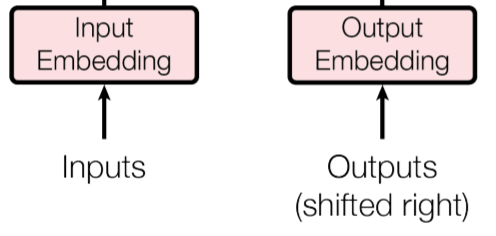

In [11]:
# Embedding Layer
# 词向量编码层
# 输入 (batch_size, seq_len)
# 输出 (batch_size, seq_len, d_model)
class EmbeddingLayer(nn.Module):

    def __init__(self, vocab_size, d_model):
        # vocab_size，词表大小
        # d_model = 512，词向量维度
        super(EmbeddingLayer, self).__init__()
        self.embedding = nn.Embedding(vocab_size, d_model)
        # 每个词表示为 one-hot 形式 (1, vocab_size)
        # 对于每个词来说 (1, vocab_size) * (vocab_size, d_model) = (1, d_model)
        # 就转化为了一个 d_model(512) 维的词向量
        # 词向量的embedding矩阵 (vocab_size, d_model)
        # 在这里这个矩阵是随机初始化的，是待训练的参数
        # nn.Embedding.weight 的默认随机初始化方式是标准正态分布 N(0,1)
        self.d_model = d_model

    def forward(self, x):
        # x (batch_size, seq_len)
        
        # return self.embedding(x)
        # (batch_size, seq_len, d_model)
        
        output = self.embedding(x) * math.sqrt(self.d_model)
        
        print("\n------------EmbeddingLayer---------------")
        print(f"input size {x.size()}")
        print(f"output size {output.size()}")
        print("-------------------------------------------")

        return output
        # (batch_size, seq_len, d_model)
        
        # 为什么要乘以 embedding_size 的开方
        # 如果 Embedding 矩阵的初始化形式是 Xavier init
        # 这种初始化方式的方差是 1/embedding_size
        # 所以乘以 embedding_size 的开方使得 Embedding 矩阵的方差为1
        # 更有利于训练时 Embedding 矩阵参数的收敛

In [12]:
input_embedding = EmbeddingLayer(data.src_vocab_size, config.d_model)
input_embedding

EmbeddingLayer(
  (embedding): Embedding(7, 8)
)

In [13]:
for batch in train_loader:
    input_embedding_out = input_embedding(batch['input_ids'])
    print(input_embedding_out)


------------EmbeddingLayer---------------
input size torch.Size([2, 4])
output size torch.Size([2, 4, 8])
-------------------------------------------
tensor([[[-0.5831,  5.5812,  2.1716,  1.5817,  2.7495, -3.8437,  0.2437,
           0.4154],
         [-4.4554, -0.7912,  0.5881,  2.9038, -4.4751,  1.7979,  1.3545,
          -0.0165],
         [-0.3659, -2.4980, -3.8203, -4.9274, -0.0901,  4.6765, -1.0223,
          -0.4315],
         [-2.7511, -0.3307, -4.6016,  0.4917,  2.2537, -2.5491, -4.5521,
          -3.6562]],

        [[-0.5831,  5.5812,  2.1716,  1.5817,  2.7495, -3.8437,  0.2437,
           0.4154],
         [-2.3667,  0.3083, -2.4414,  0.4116,  1.5202, -0.8880,  0.2342,
           0.3581],
         [ 3.3584,  1.8120, -3.4437,  0.5024,  2.0285,  1.4198, -1.2128,
          -0.3282],
         [ 0.1170, -2.1393, -3.2758,  6.8957, -1.0617,  0.5691,  0.4130,
           0.1645]]], grad_fn=<MulBackward0>)


- 可以看到，两个句子中的每个词，都被转化为了一个8维的向量表示
- 这个表示，就是它的词向量（word embedding）
- 只不过这个词向量是还没训练的，是通过随机初始化来的
- 目标端的输入也是同理，通过 Embedding 层，转为了一个(batch_size, seq_len, d_model)的矩阵

# Positional Encoding

- Embedding层之后接的是位置编码层
- Transformer 放弃了使用RNN作为特征提取器，使用纯注意力机制的模型，在并行程度上大大提升
- 但是RNN的自回归的模式天然是包含时序信息的，而时序信息在自然语言处理中是非常重要的（一个词语在句子的不同位置可能就代表不同的语义）
- 所以需要在编码过程中加入位置的信息

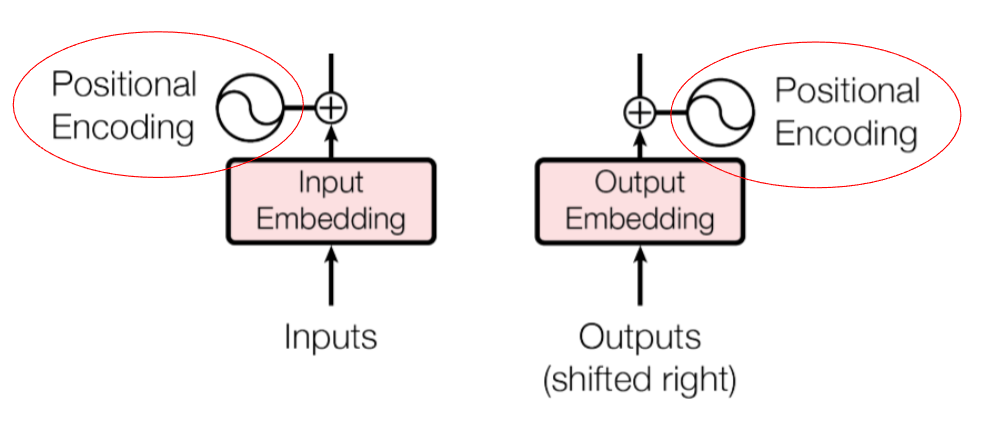

- 位置编码的意义是为了区分一个序列中的不同位置
- 所以不同位置的位置编码信息不同
- 位置编码可以通过公式计算，或者随机初始化然后进行训练
- Transformer 论文中使用的公式计算， BERT中使用的是当做参数进行训练
- 论文中的位置编码公式如下：

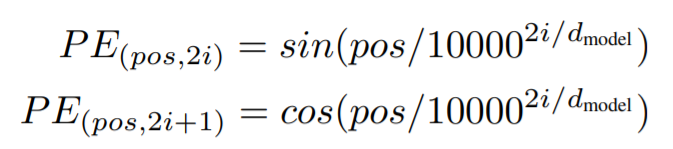

In [14]:
# Positional Encoding
# 位置编码
# 输入 (batch_size, seq_len, d_model)
# 输出 (batch_size, seq_len, d_model)
class PositionalEncoding(nn.Module):

    def __init__(self, d_model, dropout, max_len=1000):
        # d_model = 512
        # dropout = 0.1
        # max_len 代表事先准备好长度为1000的序列的位置编码，这个数值一般和设定的序列最长长度相等
        # 假设设定序列最长长度为1000，序列长于1000的部分会直接被截断
        # 所以就只需要位置到1000的位置编码
        super(PositionalEncoding, self).__init__()
        self.dropout = nn.Dropout(p=dropout)

        pe = torch.zeros(max_len, d_model)
        # 初始化一个 (1000, 512) 的矩阵，用于保存每个位置的位置编码，一共1000个位置
        # 每个位置用一个和词的embedding维度相同的向量（512）来表示
        # 方便后面相加
        position = torch.arange(0, max_len).unsqueeze(1)
        # (1000) -> (1000, 1)
        div_term = torch.ones(int(d_model / 2)) / (10000.0 ** (torch.arange(0, d_model, 2) / float(d_model)))
        # 位置编码sin、cos临边固定的那个部分
        # 这里注意！！！公式里边的那个 i 代表的是维度，就是512维的第1维、第2维...第512维，而不是位置，这里容易搞混
        # 一共(0, 2, ..., 510)，256个值，分别对应512维的奇数维和偶数维
        
        # ----------------------------------------------------- #
        # Transformer源码中用的是下边这个写法
        # div_term = torch.exp(torch.arange(0, d_model, 2) * -(math.log(10000.0) / d_model))
        # 这个写法对公式进行了数学变形
        # ----------------------------------------------------- #
        
        pe[:, 0::2] = torch.sin(position * div_term)
        # 偶数维度
        pe[:, 1::2] = torch.cos(position * div_term)
        # 奇数维度
        pe = pe.unsqueeze(0)
        # (1000, 512) -> (1, 1000, 512) 为batch_size留出位置
        self.register_buffer('pe', pe)
        # 位置编码是不会更新的，是写死的，所以这个class里没有可训练的参数

    def forward(self, x):
        # x (batch_size, seq_len, d_model)
        
        print("\n------------Positional Encoding---------------")
        print(f"input size {x.size()}")
        
        x = x + self.pe[:, :x.size(1)]
        # 这一层接收的 x 是 Embeddings 层的输出结果
        # 然后把自己的位置编码，进行对位相加
        # x (2, 4, 8)
        # self.pe[:, :x.size(1)] 就取的是min(4, 1000)
        # 在一个 batch 中的2个序列，相同的位置加的都是一样的值
        

        print(f"output size {x.size()}")
        print("-------------------------------------------")
        
        
        return self.dropout(x)
        # 增加一个dropout操作

- pe矩阵(1000,d_model)代表了1000个位置的位置编码，每行一个
- 每个位置的位置编码都是不同
- 当 d_model = 512 时，看一下位置编码的值的分布（每行是一个位置的编码）

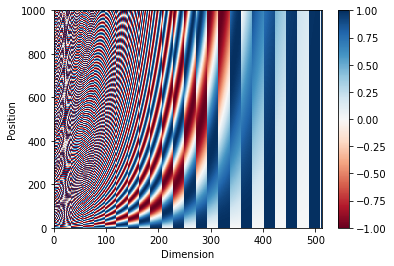

In [15]:
positionl_encoding = PositionalEncoding(512, dropout=0.1)
# 绘制位置编码
def plot_position_embedding(position_embedding):
    plt.pcolormesh(position_embedding[0],cmap='RdBu') # 【50*512】
    plt.xlabel('Dimension')
    plt.xlim((0,512))
    plt.ylabel('Position')
    plt.colorbar()
    plt.show()

plot_position_embedding(positionl_encoding.pe)

- 回到上面的例子，从Embedding层中出来的向量维度为(2, 4, 8)
- 这个向量经过位置编码层的时候，会加上对应位置的位置编码信息，再往下传

In [16]:
input_embedding = EmbeddingLayer(data.src_vocab_size, config.d_model)
positionl_encoding = PositionalEncoding(config.d_model, dropout=0)
for batch in train_loader:
    input_embedding_out = input_embedding(batch['input_ids'])
    positionl_encoding_out = positionl_encoding(input_embedding_out)
    print(positionl_encoding_out)


------------EmbeddingLayer---------------
input size torch.Size([2, 4])
output size torch.Size([2, 4, 8])
-------------------------------------------

------------Positional Encoding---------------
input size torch.Size([2, 4, 8])
output size torch.Size([2, 4, 8])
-------------------------------------------
tensor([[[ 1.4599,  2.1464, -5.4738,  0.9370, -1.2153,  2.1165,  4.2871,
          -2.4274],
         [ 0.8736, -1.9363,  2.7218, -0.3042, -1.0029,  1.3153, -2.6105,
           3.0436],
         [-0.5758,  2.0706, -0.1183,  2.1299, -0.5179,  4.9116, -2.1212,
          -0.7740],
         [-1.1950,  0.8197, -2.2037,  4.2596, -1.0035,  1.7399,  2.7833,
           3.7047]],

        [[ 1.4599,  2.1464, -5.4738,  0.9370, -1.2153,  2.1165,  4.2871,
          -2.4274],
         [ 0.7924, -0.5216,  3.4087, -0.3418, -1.8365, -2.4697,  2.2229,
           1.3667],
         [ 6.2631,  2.8932,  1.2280,  2.4302, -6.6540,  1.2395, -0.3912,
          -2.8614],
         [-0.9741, -2.2353,  1.9671, 

- 在具体使用时，可以不必像上面那段一样在每一步生成一个输出
- 可以直接通过 PyTorch 的 nn.Sequential 把两个层连接起来
- 像下面这样

In [17]:
embedding = nn.Sequential(EmbeddingLayer(data.src_vocab_size, config.d_model), PositionalEncoding(config.d_model, dropout=0)) 
for batch in train_loader:
    embedding_out = embedding(batch['input_ids'])
    print(embedding_out.size())


------------EmbeddingLayer---------------
input size torch.Size([2, 4])
output size torch.Size([2, 4, 8])
-------------------------------------------

------------Positional Encoding---------------
input size torch.Size([2, 4, 8])
output size torch.Size([2, 4, 8])
-------------------------------------------
torch.Size([2, 4, 8])


# Attention Module

- 从参与attention的序列的角度，Transformer 中使用的 attention 机制分为两种
    - 一种是在 Encoder 和 Decoder 都用到的自注意力机制（self-attention），图中红色的部分
    - 另外一种是只有 Decoder 端用到的源端-目标端注意力机制（src-trg attention），图中蓝色的部分
- 从图中可以看出，self-attention 和 src-trg attention 的区别在于，送入注意力机制模型进行计算的矩阵不同。
- 在 self-attention 的部分，模型接收的三个输入（Q、K、V矩阵）均来自同一个序列（源端或者目标端）
- 在 src-trg attention 的部分，模型接收的三个输入，有两个来自源端（K、V矩阵），有一个来自目标端（Q矩阵）

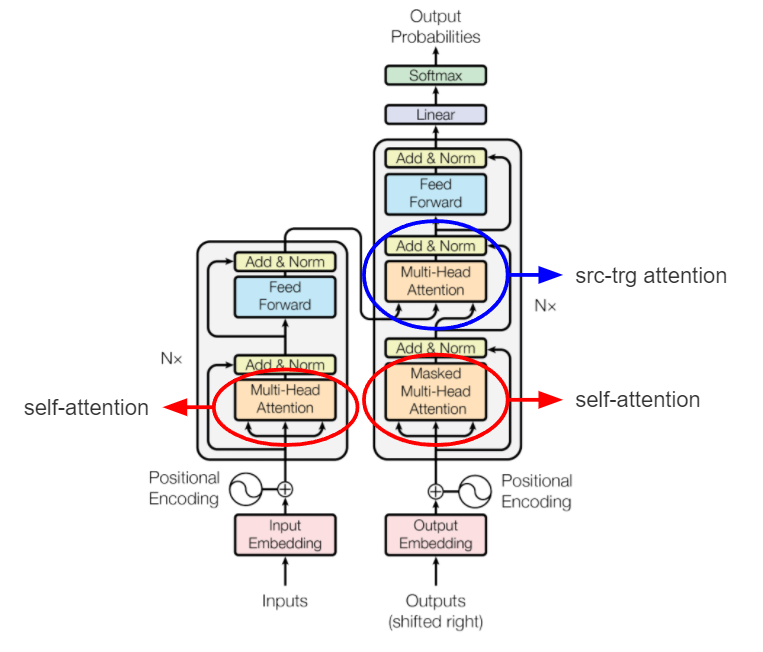

## 注意力机制
- 这里稍微解释一下注意力机制的原理，具体可以参考这个链接：[张俊林：深度学习中的注意力模型](https://zhuanlan.zhihu.com/p/37601161)。
- 注意力机制就是将源端的构成元素当做一系列的键值对（<Key,Value>），给定目标端中某个元素的Query，通过计算Query和源端每个元素的Key的相关性，得到每个Key对应的权重系数，然后求Value加权和，这个值就是目标端中这个元素对于源端中每个元素的注意力打分。
- 所以本质上注意力机制是对源端中元素的Value值进行加权求和，而Query和Key用来计算对应Value的权重系数。
- 上面提到的 self-attention 和 src-trg attention 的区别就在于，self-attention 的源端序列和目标端序列是同一个序列，所以 Query、Key、Value 都来自于同一个序列，而 src-trg attention 的源端序列和目标端序列是不同的（在这里分别对应两种不同语言的句对），所以 Query 来自目标端，Key、Value 来自源端。

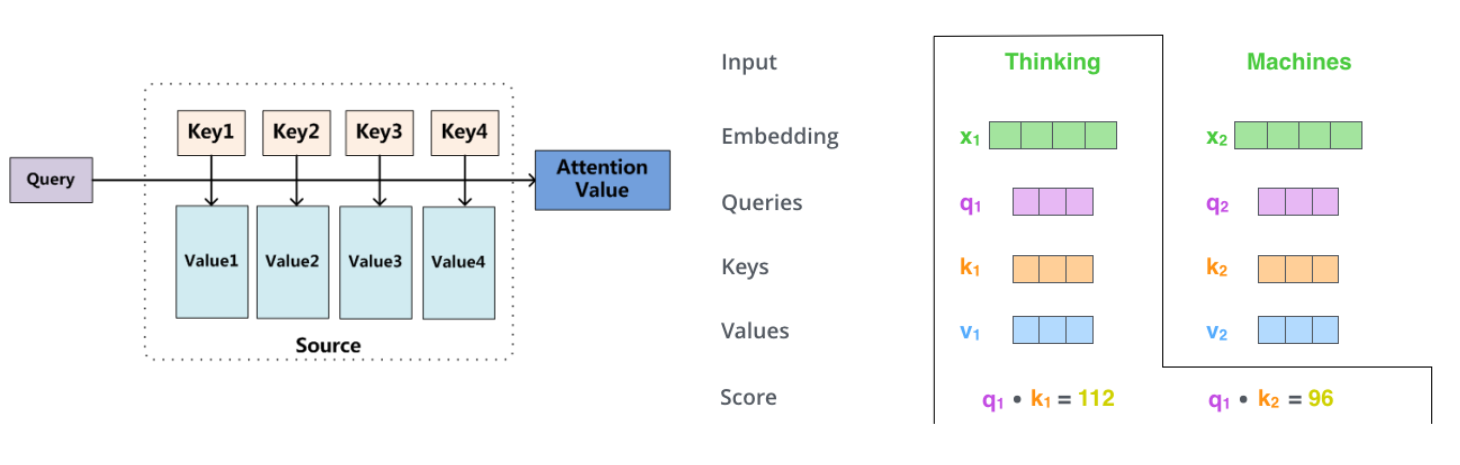

## Query，Key，Value 是从哪来的？
- 从模型图我们可以看到，经过 Embedding 和 Positional Encoding 的向量矩阵，被复制为了3份，直接送入了 Attention 模块
- 从本质上来说，Query、Key、Value 都是输入的向量 Embedding，只不过它们分别代表向量向量D的不同属性
- 从代码实现的角度，通过三个映射矩阵 $W^Q,W^K,W^V$，将输入的 Embedding 向量映射为三个不同的向量 Query、Key、Value
- 映射矩阵 $W^Q,W^K,W^V$ 的参数是随机初始化的，是模型需要训练的参数

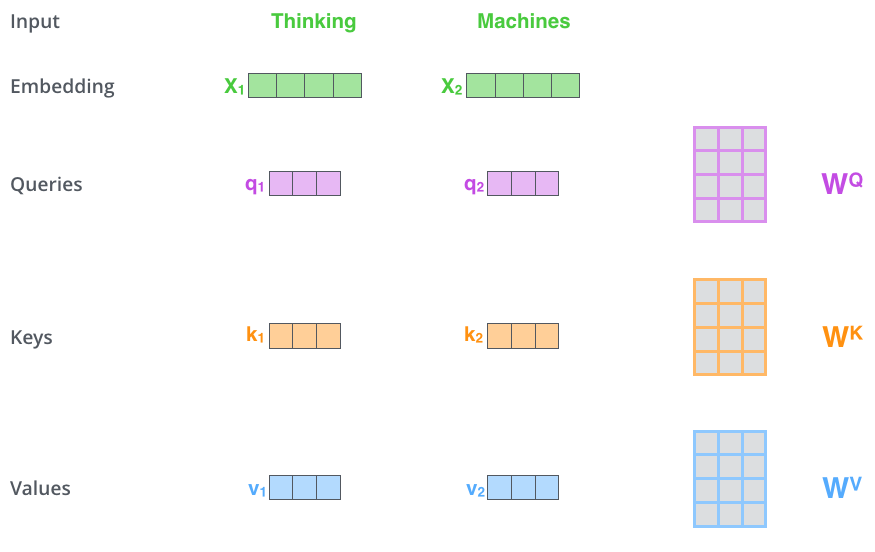

## Scaled Dot-Product Attention

- 缩放点积注意力机制
- 这是一种特殊的注意力机制，可以从图中看出，和基础的注意力机制相比，区别就在于在Query和Key相乘之后，把这个值除以Key的维度$\sqrt{d_k}$，然后再送入softmax计算每个Key的权重系数

- 为什么要除以$\sqrt{d_k}$？
    - 由于softmax函数的特性，当有的词语Query和Key的点积太大（即词语之间的相关度差距过大）时，softmax函数会使得这种结果被放大，相关度大的权重系数接近于1，相关度小的权重系数接近于0，这并不符合我们所要的，结合上下文信息的初衷，除以$\sqrt{d_k}$，能缓解这种词语之间相关度过大的情况
    - 从反向传播角度来看，除以 $\sqrt{d_k}$可以避免点积过大将softmax结果推向极小梯度的区域，缓解梯度消失的情况
    - $W^Q,W^K$的各个分量是随机初始化的，假设初始化方式为标准正态分布 N(0,1)，那么Query和Key的点积结果均值是0，方差是$d_k$，除以$\sqrt{d_k}$能把点积调回均值0，方差1的正态分布

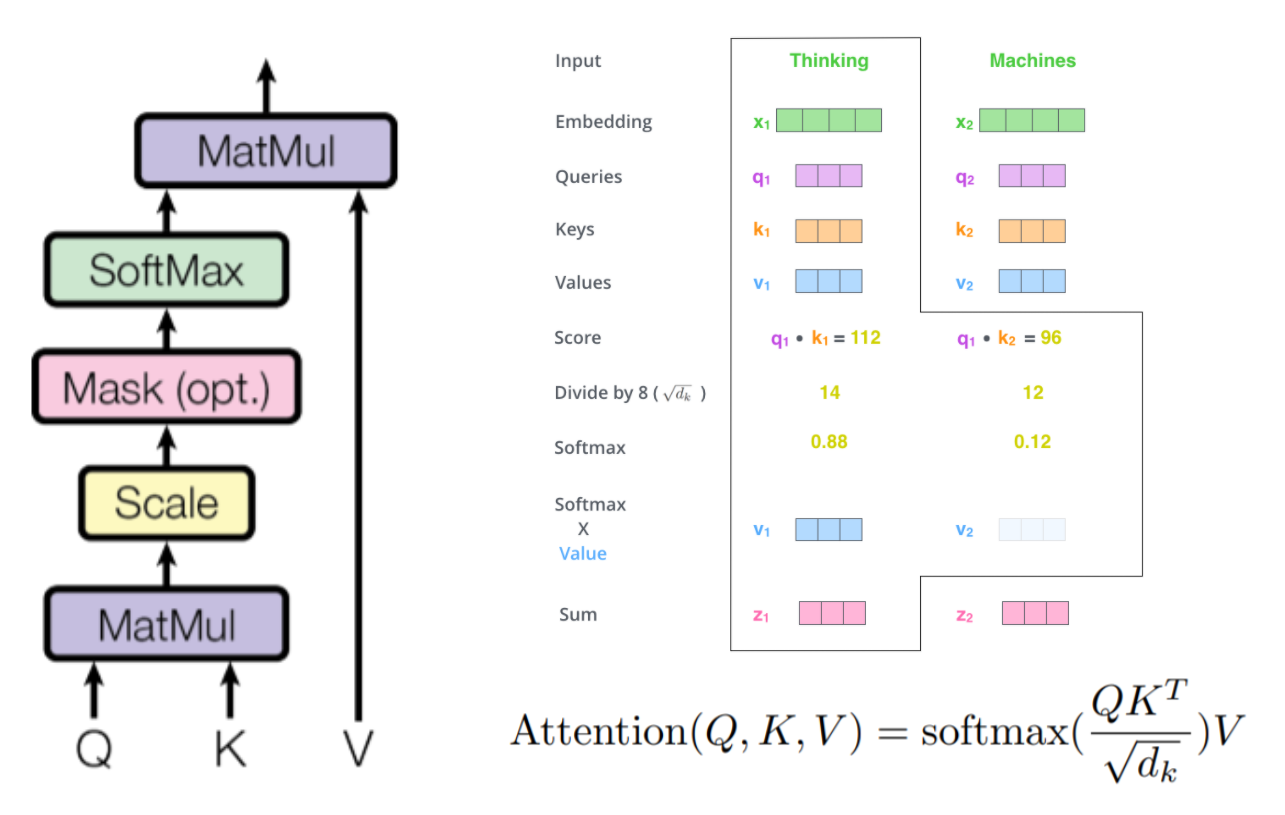

In [18]:
# scaled dot-product attention
# 缩放点积注意力机制
# 公式
# attention(Q,K,V) = softmax(QK^T/sqrt(d_k))*V

# 输入 (batch_size, head_num, trg_seq_len, d_q)，
#      (batch_size, head_num, src_seq_len, d_k)，
#      (batch_size, head_num, src_seq_len, d_v)
# 输出 (batch_size, head_num, trg_seq_len, d_v)

# 这部分中的 src 和 trg 代表的是进行注意力机制的两个序列
# 在 self-attention 中就是两个一样的句子，在 src-trg attention 中才是源端和目标端的序列

def scaled_dot_product_attention(query, key, value, mask=None, dropout=None):
    # 在每个注意力头上
    # Q，K，V 的形状为 (batch_size, head_num, seq_len, d_k)
    # head_num * d_k = d_model 比如在一个512维8头的 Transformer 中，d_k = 64
    d_k = query.size(-1)
    # 获得Q，K的维度 d_k
    scores = torch.matmul(query, key.transpose(-1, -2)) / math.sqrt(d_k)
    # (batch_size, head_num, trg_seq_len, d_k) * (batch_size, head_num, d_k, src_seq_len)
    # (batch_size, head_num, trg_seq_len, src_seq_len)
    # 这个(trg_seq_len * src_seq_len)的矩阵的中值，就是目标端句子中每个单词对于源端句子中每个单词的注意力得分

    # 在一个 batch 中并不是所有数据都是等长的，所以有些句子中会有[Pad]这种填充项
    # 这些[Pad]在经过上面那一步也会计算出一个分数
    # 如果不管它们，把它们送入softmax，那么它们也会产生一定的权重，这是我们不愿意看到的
    # 所以我们要通过mask，消除它们的影响
    if mask is not None:
        scores = scores.masked_fill(mask == 0, -1e9)
        # 使用mask，对已经计算好的scores，按照mask矩阵，填上-1e9
        # 在下一步计算softmax的时候，被设置成-1e9的数对应值约等于0，被忽视

    attention_map = F.softmax(scores, dim=-1)
    # 对score的最后一维做softmax，算出每个目标端Query的权值

    if dropout is not None:
        attention = dropout(attention_map)

    return torch.matmul(attention, value), attention_map
    # 拿权重系数乘以Value，得到注意力
    # attention_map 用于可视化两个序列之间的注意力情况

## mask

- 在 Transformer 中，需要用到的 mask 机制有两种
    - mask掉填充项\[Pad\]，消除其影响
    - 在decoder端的self-attention部分，在输入每一个位置时，要把后面的位置mask掉，防止在当前位置窥视到后面的信息（相当于让模型作弊）

- \[Pad\]项的mask只需对输入端和输出端的序列做一个简单的处理，判断一下是否是\[Pad\]即可

In [19]:
for batch in train_loader:
    print(batch['input_ids'])
    src_mask = (batch['input_ids'] != 0)
    src_mask = src_mask.unsqueeze(-2)
    print(src_mask)

tensor([[1, 2, 3, 4],
        [1, 5, 6, 0]])
tensor([[[ True,  True,  True,  True]],

        [[ True,  True,  True, False]]])


- 这个mask矩阵用于encoder端的self-attention模块和decoder端的src-trg attention模块内，用于消除自注意力机制计算时\[Pad\]的影响

- 在decoder端的self-attention模块，在对每一个输入端的词计算自注意力时，要注意一个点，我们在真正应用场景下，比如机器翻译中，目标端的词语是一个一个生成出来的，所以在生成每一个位置的词语时，它是看不到后面词语的信息的，比如在下面这个例子中，机器翻译出当我们得到第一个词 i 的时候，肯定是还不知道后面的 want a beer 的
- 所以为了避免训练和真实使用时存在gap，导致模型泛化能力差，在训练时将当前单词的未来信息屏蔽掉，阻止此单词关注到后面的单词。
- 如图所示，使用可以使用上三角矩阵来mask掉后面位置的词语

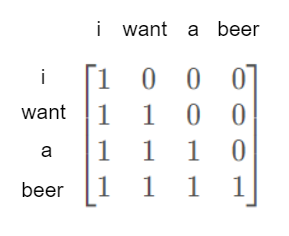

In [20]:
def upper_triangular_mask (size):

    mask_shape = (1, size, size)
    mask = np.triu(np.ones(mask_shape), k=1)
#     [[[0. 1. 1. 1.]
#       [0. 0. 1. 1.]
#       [0. 0. 0. 1.]
#       [0. 0. 0. 0.]]]
    
    return torch.from_numpy(mask) == 0

print(upper_triangular_mask(4))

tensor([[[ True, False, False, False],
         [ True,  True, False, False],
         [ True,  True,  True, False],
         [ True,  True,  True,  True]]])


- 由于decoder端的序列中也会包含\[pad\]项，所以在decoder端使用的mask矩阵需要是上三角mask矩阵和\[Pad\]mask矩阵的交集

In [21]:
def make_trg_mask(trg, pad_id):
    trg_mask = (trg != pad_id).unsqueeze(-2)
    trg_mask = trg_mask & upper_triangular_mask(trg.size(-1))
    return trg_mask

for batch in train_loader:
    print(batch['output_ids'])
    trg_mask = make_trg_mask(batch['output_ids'], 0)
    print(trg_mask)

tensor([[7, 1, 2, 3, 4],
        [7, 1, 5, 6, 0]])
tensor([[[ True, False, False, False, False],
         [ True,  True, False, False, False],
         [ True,  True,  True, False, False],
         [ True,  True,  True,  True, False],
         [ True,  True,  True,  True,  True]],

        [[ True, False, False, False, False],
         [ True,  True, False, False, False],
         [ True,  True,  True, False, False],
         [ True,  True,  True,  True, False],
         [ True,  True,  True,  True, False]]])


## 并行化计算

- 在 Transformer 中，计算 attention 的部分并不是一个一个样本计算的
- 而是将整个 batch 的数据以矩阵的形式进行批量的并行化运算，这样能够大大加快训练的速度
- 过程如图所示，在函数 scaled_dot_product_attention 中，所有数据都是通过矩阵来进行运算的

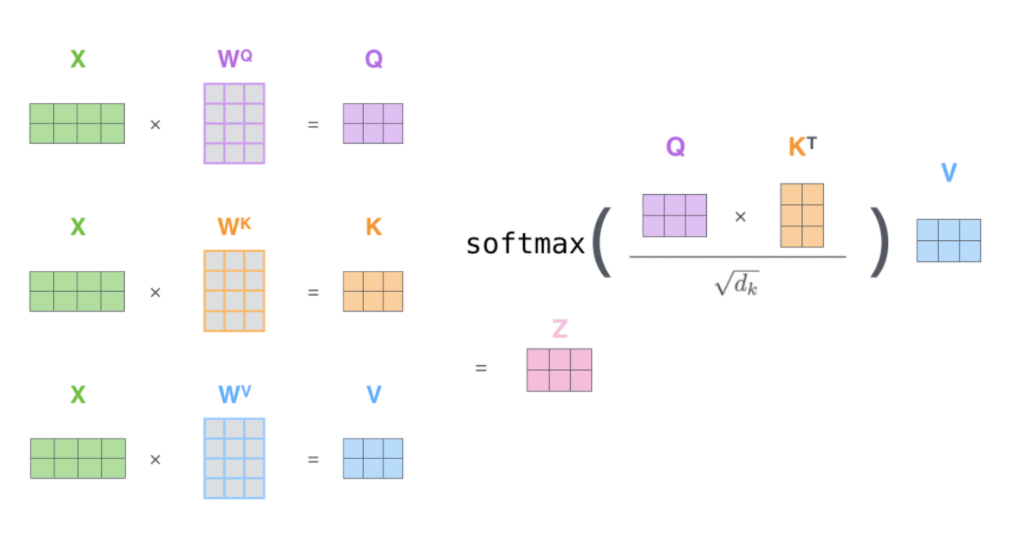

## Multi-Head Attention

- 多头注意力机制
- 上面提到，参数矩阵 $W^Q,W^K,W^V$ 用于将 Embedding 映射为Query，Key和Value，而每组 $W^Q,W^K,W^V$ 参数矩阵，被称为一个“注意力头”
- 论文中提到，每个注意力头用于关注每个词语在不同空间的信息（从实践角度来说，就是作者发现这样效果比较好）
- 多头注意力的公式和模型图如下图所示

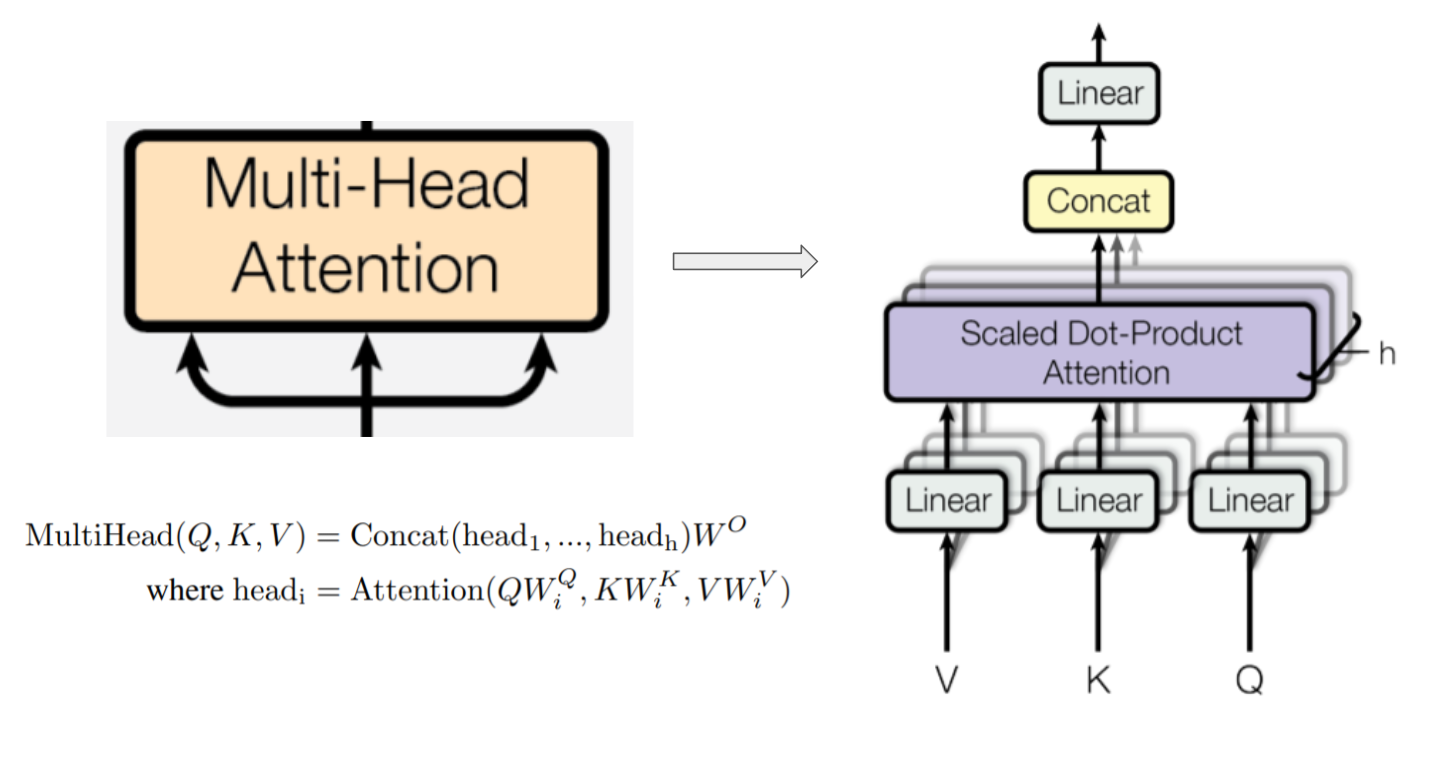

- 从理论上来讲，如果有8个注意力头，那么就需要8组不同的 $W^Q,W^K,W^V$ 矩阵，从而通过 $softmax(QK^T/\sqrt{d_k})*V$ 生成8个不同的注意力结果
- 然后将8个注意力结果进行拼接，再送入一个线性层，将向量维度映射回到词向量维度（512）
- 如果使用这种方式，那么一个多头注意力层的参数量（以8头为例）
    - 8组 $W^Q,W^K,W^V$ 矩阵（d_model, d_k）
    - 1个线性层 (8 * d_k, d_model)
- 具体过程如下图所示

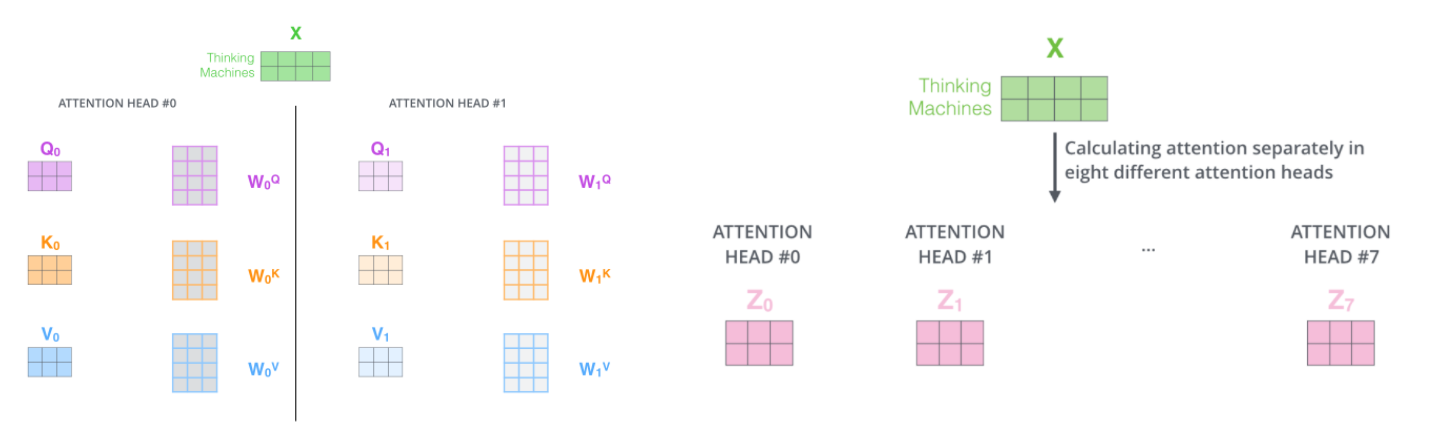
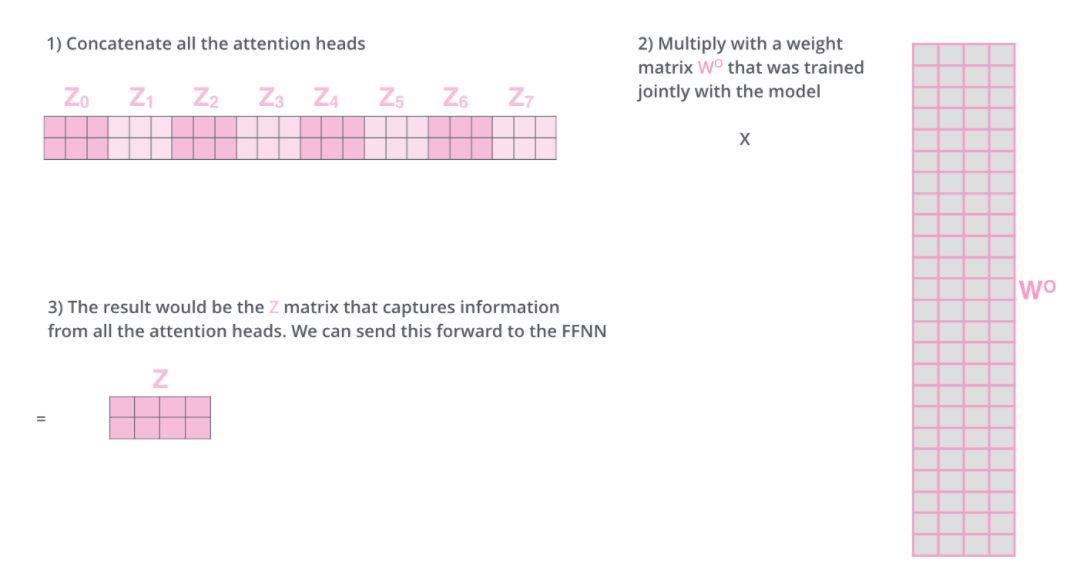

- 上面说的那种方式，参数量巨大
    - 对于数据量的要求很高，如果数据量不够，很容易过拟合
    - 收敛速度较慢
- 所以在实际应用中，一般采取另外一种方式（下面的代码中用的就是这种方式）
    - 以512维，8头举例
    - 采用一组 $W^Q,W^K,W^V$ 矩阵（512,512），将 embedding 映射为同维度的 Query，Key，Value 矩阵（512 -> 512,512,512）
    - 将 Query，Key，Value 矩阵切分为8等份（512，512，512 -> 64，64，64）
    - 这8等份的 Query，Key，Value 矩阵分别代表8个注意力头，送入缩放点积注意力函数进行计算（64，64，64 -> 64）
    - 将这8个头得到注意力进行拼接（8 * 64 -> 512）
    - 再把这个注意力结果送入一个线性层（512,512），得到多头注意力层的结果
- 这样参数量就被减为了
    - 1组 $W^Q,W^K,W^V$ 矩阵（d_model, d_model）
    - 1个线性层（d_model, d_model）

In [22]:
# 多头注意力层
# 这里的“多头”，并不是用了多套的 Q，K，V 矩阵
# 而是用一套 Q，K，V 矩阵映射完之后，再把结果拆成多个
# 多头使得模型能够从多个角度去理解内容，提取到多个维度的特征
# 简单来说，就是效果更好
class MultiHeadedAttention(nn.Module):

    def __init__(self, h, d_model, dropout=0.1):
        # h=8, d_model=512
        super(MultiHeadedAttention, self).__init__()
        assert d_model % h == 0
        # 注意力头必须是维度的倍数（词向量才能被正好分成n个头）
        self.d_k = d_model // h
        # d_k = 512//8 = 64
        self.h = h
        
        self.w_q = nn.Linear(d_model, d_model)
        self.w_k = nn.Linear(d_model, d_model)
        self.w_v = nn.Linear(d_model, d_model)
        self.linear = nn.Linear(d_model, d_model)
        # 定义四个线性层，每个大小是(512, 512)
        # 其中前三个是 Query，Key，Value 的映射矩阵，第四个是多头注意力层最后经过的一个线性层
        # 每个线性层里边有两类训练参数
        # weight (512, 512) 以及 bias (512)

        self.attention = None
        self.dropout = nn.Dropout(p=dropout)

    def forward(self, query, key, value, mask=None):
        
        print("\n------------Attention Layer---------------")
        print(f"input size {query.size()}")
        print("这里送入的三个矩阵需要经过W_Q、W_K、W_V参数矩阵的映射（这里是维度相等的映射），才能得到QKV矩阵")

        if mask is not None:
            mask = mask.unsqueeze(1)

        batch_size = query.size(0)
        
        query = self.w_q(query).view(batch_size, -1, self.h, self.d_k).transpose(1, 2)
        key = self.w_k(key).view(batch_size, -1, self.h, self.d_k).transpose(1, 2)
        value = self.w_v(value).view(batch_size, -1, self.h, self.d_k).transpose(1, 2)
        # 将 Q，K，V 分别送入对应的映射矩阵，得到的结果根据注意力头个数，拆成n份，然后把第1维和第2维对换一下
        # Q (batch_size, seq_len, d_model) -> w_q -> (batch_size, seq_len, d_model) -> view
        # -> (batch_size, seq_len, h, d_k) -> (batch_size, h, seq_len, d_k)
        # K,V 类似
        
        print("QKV矩阵被被分割为n_head（注意力头数）份，分别代表模型在不同注意力头上的QKV矩阵")
        print("\n每个注意力头上的QKV矩阵维度：")
        
        print(f"query matrix size: {query.size()}")
        print(f"key matrix size:   {key.size()}")
        print(f"value matrix size: {value.size()}")

        x, self.attention = scaled_dot_product_attention(query, key, value, mask=mask, dropout=self.dropout)
        # 调用上面的缩放点积注意力函数
        # 输出形状和输入形状相同
        # attention (batch_size, h, trg_seq_len, src_seq_len)
        # 比如这里 (2, 2, 4, 4)
        # 意义：对于一个batch中的2个样本，在2个头中，对于目标端的个4词，源端的4个词分别的注意力
        
        print("\n通过公式计算，得到每个注意头上的词语之间注意力")
        print("attention map: ")
        print(self.attention.size())
        # print(self.attention)
        
        
        x = x.transpose(1, 2).contiguous().view(batch_size, -1, self.h * self.d_k)
        # 对多头的结果进行拼接，并把形状恢复原状
        # (batch_size, head_num, trg_seq_len, d_v) -> (batch_size, trg_seq_len, d_model)
        
        
        print("\n将多头注意力的结果进行拼接，并把形状恢复为原状")
        print(f"output size {x.size()}")
        print("-----------------------------")
        
        return self.linear(x)
        # 执行最后一个线性层
        # (batch_size, trg_seq_len, d_model) -> (batch_size, trg_seq_len, d_model)

In [23]:
encoder_self_attention = MultiHeadedAttention(8, 512)
encoder_self_attention

MultiHeadedAttention(
  (w_q): Linear(in_features=512, out_features=512, bias=True)
  (w_k): Linear(in_features=512, out_features=512, bias=True)
  (w_v): Linear(in_features=512, out_features=512, bias=True)
  (linear): Linear(in_features=512, out_features=512, bias=True)
  (dropout): Dropout(p=0.1, inplace=False)
)

In [24]:
embedding = nn.Sequential(EmbeddingLayer(data.src_vocab_size, config.d_model), PositionalEncoding(config.d_model, dropout=0)) 
encoder_self_attention = MultiHeadedAttention(config.n_heads, config.d_model, dropout=0)
for batch in train_loader:
    embedding_out = embedding(batch['input_ids'])
    attention_out = encoder_self_attention(embedding_out, embedding_out, embedding_out)


------------EmbeddingLayer---------------
input size torch.Size([2, 4])
output size torch.Size([2, 4, 8])
-------------------------------------------

------------Positional Encoding---------------
input size torch.Size([2, 4, 8])
output size torch.Size([2, 4, 8])
-------------------------------------------

------------Attention Layer---------------
input size torch.Size([2, 4, 8])
这里送入的三个矩阵需要经过W_Q、W_K、W_V参数矩阵的映射（这里是维度相等的映射），才能得到QKV矩阵
QKV矩阵被被分割为n_head（注意力头数）份，分别代表模型在不同注意力头上的QKV矩阵

每个注意力头上的QKV矩阵维度：
query matrix size: torch.Size([2, 2, 4, 4])
key matrix size:   torch.Size([2, 2, 4, 4])
value matrix size: torch.Size([2, 2, 4, 4])

通过公式计算，得到每个注意头上的词语之间注意力
attention map: 
torch.Size([2, 2, 4, 4])

将多头注意力的结果进行拼接，并把形状恢复为原状
output size torch.Size([2, 4, 8])
-----------------------------


# Add & Norm

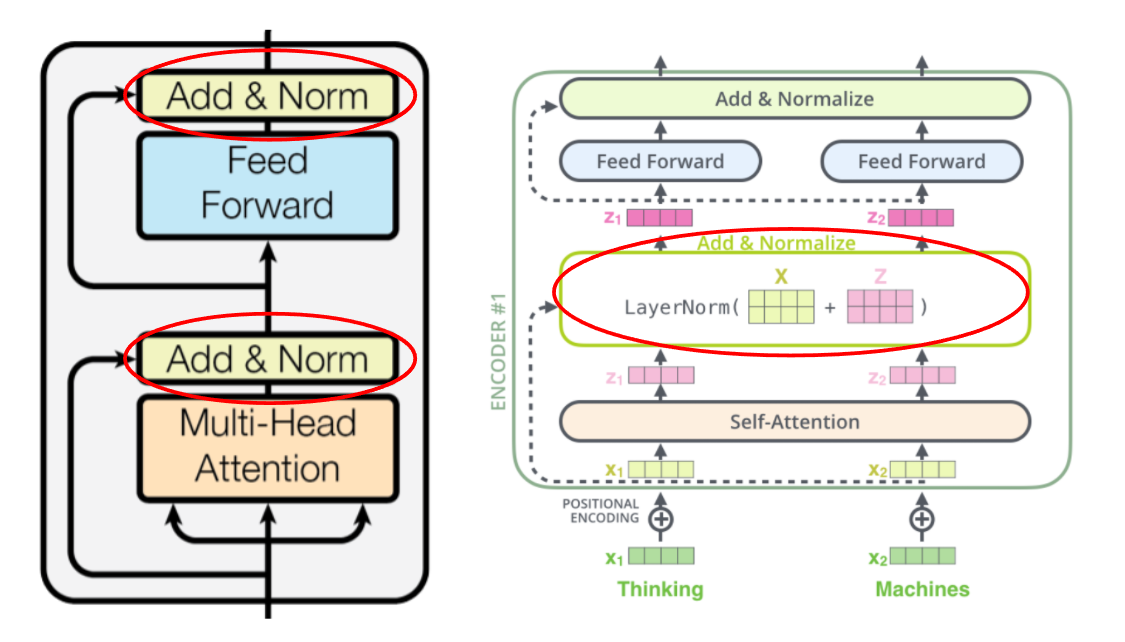

## Layer Normalization 和 Batch Normalization

- Layer Normalization 和 Batch Normalization 区别在哪 
- 举个例子
- 我们现在有一组样本，其中有两条数据，代表两个人，每条数据有两个特征，代表身高和体重
```
[[175,75]
 [180,80] ]
```
- Batch Normalization 就是在一个batch内对一个特征上的数做归一化（比如：在身高这个特征上，计算175和180的均值和方差，然后进行缩放）
- Batch Normalization 是一种列的缩放
- Layer Normalization 是对每一个样本中的所有特征做归一化（比如：在第一个人这个样本内，计算175和75的均值和方差，然后进行缩放）
- Layer Normalization 是一种行的缩放

## 为什么用 Layer Normalization

- 在一个batch中，样本的长度通常都是不同的，所以训练时有些样本中会有填充项\[Pad\]，而\[Pad\]本身是不包含任何语义信息的，但是如果使用BN，那么在对列进行归一化的时候，就会把\[Pad\]项的元素计算进去，影响真实数据的分布
- 在自然语言处理任务中，一个词语有512维的特征，对这些特征的每个维度做归一化难以说明其意义，但是如果是对词向量内部做归一化，那么能够保证这一维度上的分布不变
- 实践证明 LN 的效果要好于 BN

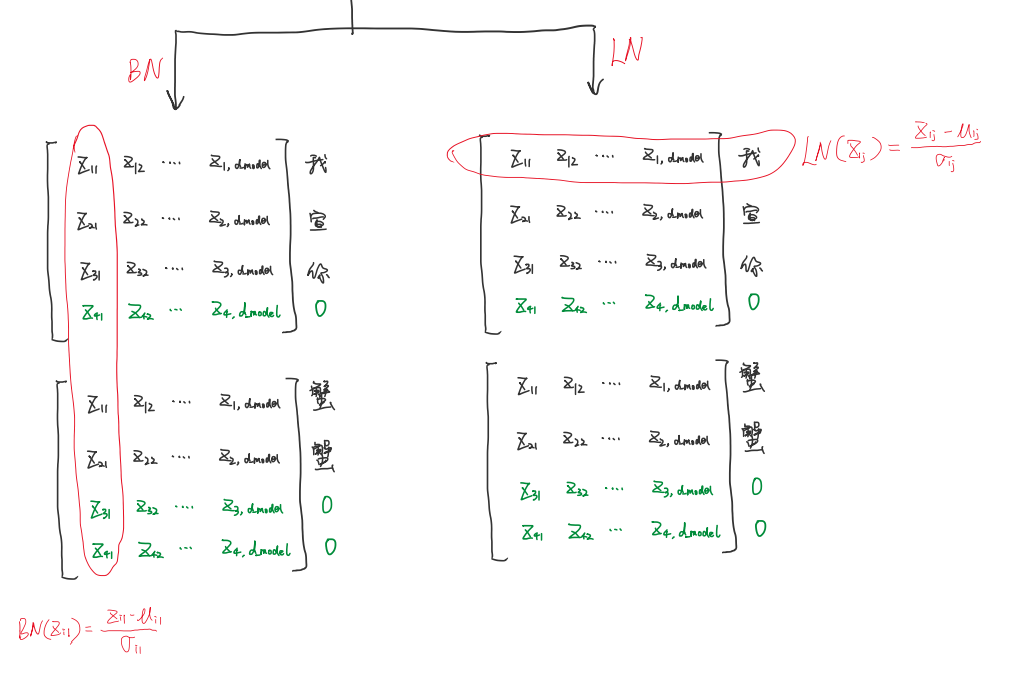

In [25]:
# 层归一化
# 输入 (batch_size, seq_len, d_model)
# 输出 (batch_size, seq_len, d_model)
class LayerNormalization(nn.Module):
    def __init__(self, features, eps=1e-6):
        # feayures = d_model
        # eps=epsilon 用于分母的非0化平滑
        super(LayerNormalization, self).__init__()
        self.a_2 = nn.Parameter(torch.ones(features))
        # a_2 是可训练参数,(512)
        self.b_2 = nn.Parameter(torch.zeros(features))
        # b_2 也是可训练参数,(512)
        self.eps = eps

    def forward(self, x):
        # x (batch_size, seq_len, d_model)
        mean = x.mean(-1, keepdim=True)
        # 对x的最后一个维度取平均值
        # (batch_size, sequence_length)
        std = x.std(-1, keepdim=True)
        # 对x的最后一个维度，取标准方差
        # (batch_size, sequence_length)
        return self.a_2 * (x - mean) / (std + self.eps) + self.b_2
        # 本质上是标准化 (x-mean)/std
        # 这里加入了两个可训练向量
        # 分母上加了一个epsilon，用来防止分母为0

## Residual 残差连接

- 如下图所示
- 采用跳跃式连接的方式，在模块向前传播时增加一个输入项
- 可以看到在求导时，无论模型的深度有多深（红色圈内有多少个连乘项），蓝色圈内的1始终保持，输入信号能够直接从低层传到高层，缓解了梯度消失的问题，使得 Transformer 能够训练到更深的层次

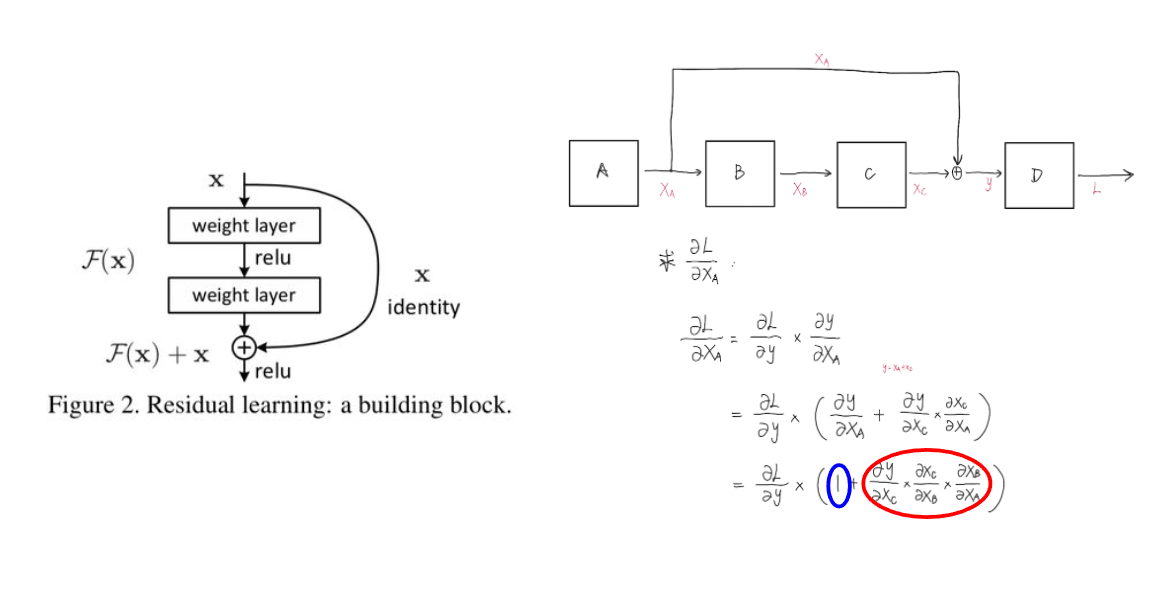

## Pre-LN 和 Post-LN

- 在 Transformer 的原文中，Layer Norm 是在每个子层（多头注意力层或者全连接层）后面做的
- 在 The Annotated Transformer 的代码中，Layer Norm 则是在矩阵传入子层（多头注意力层或者全连接层）之前
- [ON LAYER NORMALIZATION IN THE TRANSFORMER ARCHITECTURE](https://openreview.net/pdf?id=B1x8anVFPr) 这篇论文讨论了这两种方式的区别，并进行了实验测评
- BERT 源码中使用的是和 Transformer 原文一样的 Post-LN 的方式
- 下面的代码中分别实现了这两种方式

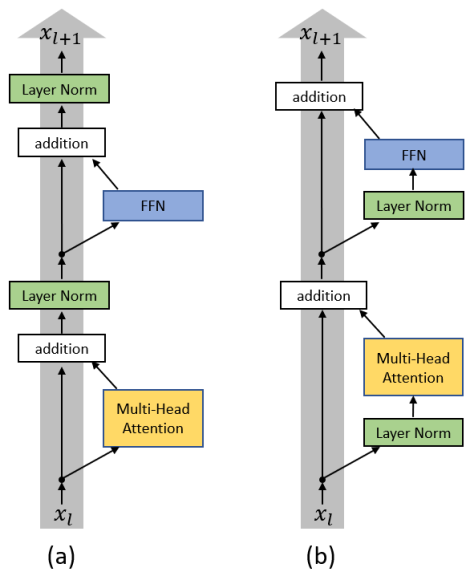

In [26]:
# 残差Add + Norm
# PostLN 最后进行归一化
class SublayerConnectionPostLN(nn.Module):

    def __init__(self, d_model, dropout=0.1):
        super(SublayerConnectionPostLN, self).__init__()
        self.norm = LayerNormalization(d_model) # 512，用于定义a_2和b_2
        self.dropout = nn.Dropout(p=dropout)

    def forward(self, x, sublayer):
        # x (batch_size, sequence_length, d_model)
        # sublayer 是一个具体的 MultiHeadAttention 或者 PositionwiseFeedForward 对象

        output = self.norm(x + self.dropout(sublayer(x)))
             
        print("\n---------------Add & Norm-------------------")
        print(f"input size {x.size()}")
        print(f"output size {output.size()}")
        print("----------------------------------------------")
        
        return output
        # x (batch_size, sequence_length, d_model)
        # x -> sublayer -> 输入的x（实现残差相加）-> layernorm -> dropout
        # 经过每个部分形状都不变

        # 这个类本身没有自己的可训练参数，self.norm中有1024个

In [27]:
# 残差Add + Norm
# PreLN 在残差之前进行归一化
class SublayerConnectionPreLN(nn.Module):

    def __init__(self, d_model, dropout=0.1):
        super(SublayerConnectionPreLN, self).__init__()
        self.norm = LayerNormalization(d_model) # 512，用于定义a_2和b_2
        self.dropout = nn.Dropout(p=dropout)

    def forward(self, x, sublayer):
        # x (batch_size, sequence_length, d_model)
        # sublayer 是一个具体的 MultiHeadAttention 或者 PositionwiseFeedForward 对象
        return x + self.dropout(sublayer(self.norm(x)))
        # x (batch_size, sequence_length, d_model)
        # x -> layernorm -> sublayer -> dropout 经过每个部分形状都不变
        # 然后加上输入的x（实现残差相加）

        # 这个类本身没有自己的可训练参数，self.norm中有1024个

# 全连接层

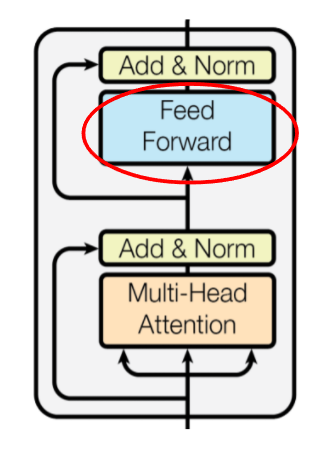

In [28]:
# 这就是个全连接层
# 其实现的是
# FFN(x) = max(0, xW_1 + b_1)W_2 + b_2
# W_1 和 b_1 是第一个线性层的参数
# max(0, xW_1 + b_1) 是 relu 激活函数
# W_2 和 b_2 是第二个线性层的参数
class FNN(nn.Module):

    def __init__(self, d_model, d_ff, dropout=0.1):
        # d_model = 512
        # d_ff = 2048 = 512 * 4
        super(FNN, self).__init__()
        self.w_1 = nn.Linear(d_model, d_ff)
        # 构建第一个全连接层 (512, 2048)
        # 其中有两种可训练参数
        # weights 矩阵 (512, 2048)， biases 偏置 (2048)
        self.w_2 = nn.Linear(d_ff, d_model)
        # 构建第二个全连接层 (2048, 512)
        # 其中有两种可训练参数
        # weights 矩阵 (2048, 512) ，biases 偏置 (512)
        self.dropout = nn.Dropout(p=dropout)

    def forward(self, x):
        # x (batch_size, sequence_len, d_model)
        print("\n--------------FNN----------------")
        print(f"input size {x.size()}")
        
        t = self.dropout(F.relu(self.w_1(x)))
        print(f"intermediate state size {t.size()}")
        
        output = self.w_2(t)
        print(f"output size {output.size()}")
        print("-----------------------------------")
        
        
        return output
        # x (batch_size, sequence_len, d_model) -> self.w_1 -> (batch_size, sequence_len, d_ff)
        # -> relu -> (batch_size, sequence_len, d_ff) -> dropout -> (batch_size, sequence_len, d_ff)
        # -> self.w_2 -> (batch_size, sequence_len, d_model)

In [29]:
fnn = FNN(512, 2048)
fnn

FNN(
  (w_1): Linear(in_features=512, out_features=2048, bias=True)
  (w_2): Linear(in_features=2048, out_features=512, bias=True)
  (dropout): Dropout(p=0.1, inplace=False)
)

# Encoder Layer

- 如下图所示
- Transformer 的一个 EncoderLayer 由下面几部分组成
    - MultiHeadAttention 多头注意力层(self-attention)
    - Add & Norm 残差连接+层归一化
    - FNN 全连接层
    - Add & Norm 残差连接+层归一化

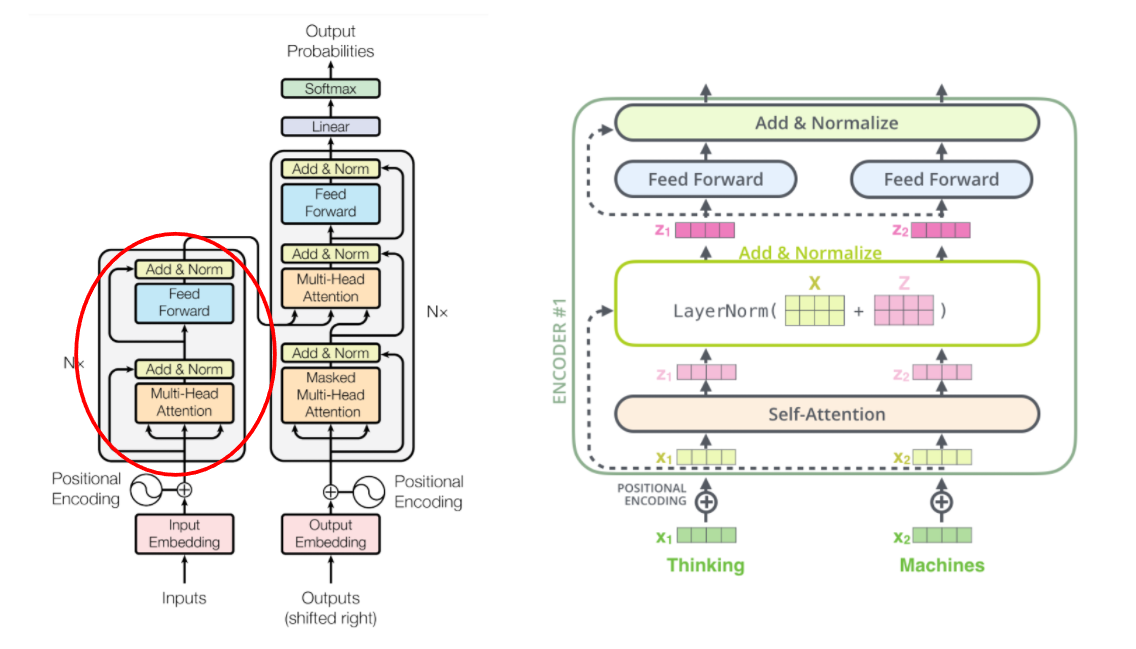

In [30]:
# 编码层（单层）
# 用于抽取输入序列的特征
# 输入 (batch_size, seq_len, d_model)
# 输出 (batch_size, seq_len, d_model)
class EncoderLayer(nn.Module):

    def __init__(self, d_model, self_attention, feed_forward, dropout=0.1):
        # self_attention 多头注意力层(第一个子层)
        # feed_forward 全连接层(第二个子层)
        super(EncoderLayer, self).__init__()
        self.attention = self_attention
        self.fnn = feed_forward
        self.sublayer_1 = SublayerConnectionPostLN(d_model, dropout)
        self.sublayer_2 = SublayerConnectionPostLN(d_model, dropout)

    def forward(self, x, mask):
        print(f"input size {x.size()}")
        print("每个 EncoderLayer 的输入是 Input Embedding + Positional Encoding 的结果，或者上一层 EncoderLayer 的输出")
        print("这个输入被复制为三份，传入 Attention 层，分别通过W_Q、W_K、W_V参数矩阵的映射，转化为QKV矩阵")
        # x (batch_size, seq_len, d_model)
        # mask 的作用类似于对于当前这个词w_trg，有其他哪些词w_src是可见的
        # 做 self-attention 的时候，所有其他词都是可见的，除了[Pad]这样的填充词
        # 做 src-trg attention的时候，除了[Pad]这样的填充词，还有w左边的词（未来信息），都是不可见的
        # （后面的词相当于参考答案，提前看了参考答案会导致模型训练不当）
        x = self.sublayer_1(x, lambda x: self.attention(x, x, x, mask))
        # 为什么使用lambda定义函数
        # 因为在 SublayerConnectionPostLN 里边，定义的 sublayer 只接收一个变量作为输入
        # 这里需要把变量复制为3份，在 DecoderLayer 里边更是需要传入别的变量
        # 所以使用lambda函数的形式来传参
        return self.sublayer_2(x, self.fnn)

In [31]:
encoder_self_attention = MultiHeadedAttention(8, 512)
fnn = FNN(512, 2048)
encoder_layer = EncoderLayer(512, encoder_self_attention, fnn)
encoder_layer

EncoderLayer(
  (attention): MultiHeadedAttention(
    (w_q): Linear(in_features=512, out_features=512, bias=True)
    (w_k): Linear(in_features=512, out_features=512, bias=True)
    (w_v): Linear(in_features=512, out_features=512, bias=True)
    (linear): Linear(in_features=512, out_features=512, bias=True)
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (fnn): FNN(
    (w_1): Linear(in_features=512, out_features=2048, bias=True)
    (w_2): Linear(in_features=2048, out_features=512, bias=True)
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (sublayer_1): SublayerConnectionPostLN(
    (norm): LayerNormalization()
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (sublayer_2): SublayerConnectionPostLN(
    (norm): LayerNormalization()
    (dropout): Dropout(p=0.1, inplace=False)
  )
)

## 为什么要使用自注意力机制
- 如果不使用注意力机制，那么每个词向量就是上下文无关的
- 通过注意力机制对词向量进行重构，使得词向量不止包含自己，而是综合考虑，融入上下文。
- 这样可以更好地抽取特征

# Encoder

- Transformer 的 Encoder 由多层的 EncoderLayer 组成
- 正是由 Transformer 开始，自然语言处理的模型开始能训练得比较深
- BERT 的模型结构用的就是 Transformer 的 Encoder
    - BERT base 用了12层的 Transformer EncoderLayer
    - BERT large 用了24层的 Transformer EncoderLayer

In [32]:
# 神经网络的深度copy
# module是要copy的模型，N是copy的份数
def clones(module, N):
    return nn.ModuleList([copy.deepcopy(module) for _ in range(N)])

In [33]:
# Encoder 编码器
# Encoder 由 N 层的 EncoderLayer 组成
# 输入 (batch_size, seq_len, d_model)
# 输出 (batch_size, seq_len, d_model)
class Encoder(nn.Module):
    # Encoder是N个的EncoderLayer层的叠加
    def __init__(self, layer, N):
        # layer = EncoderLayer, N = 6
        super(Encoder, self).__init__()
        self.layers = clones(layer, N)

    def forward(self, x, mask):
        print("\n-----------------Encoder--------------------")
        # x (batch_size, seq_len, d_model)
        # 这里的 mask 会传入每一个 EncoderLayer
        # 作为掩码，防止模型看到不需要的信息，或者防止[Pad]影响loss的计算
        for i, layer in enumerate(self.layers):
            print(f"\n------------Encoder Layer {i}---------------")
            x = layer(x, mask)
        
        print("----------------------Save the encoder result----------------------------")
        return x

In [34]:
encoder_self_attention = MultiHeadedAttention(8, 512)
fnn = FNN(512, 2048)
encoder = Encoder(EncoderLayer(512, encoder_self_attention, fnn), 6)
encoder

Encoder(
  (layers): ModuleList(
    (0): EncoderLayer(
      (attention): MultiHeadedAttention(
        (w_q): Linear(in_features=512, out_features=512, bias=True)
        (w_k): Linear(in_features=512, out_features=512, bias=True)
        (w_v): Linear(in_features=512, out_features=512, bias=True)
        (linear): Linear(in_features=512, out_features=512, bias=True)
        (dropout): Dropout(p=0.1, inplace=False)
      )
      (fnn): FNN(
        (w_1): Linear(in_features=512, out_features=2048, bias=True)
        (w_2): Linear(in_features=2048, out_features=512, bias=True)
        (dropout): Dropout(p=0.1, inplace=False)
      )
      (sublayer_1): SublayerConnectionPostLN(
        (norm): LayerNormalization()
        (dropout): Dropout(p=0.1, inplace=False)
      )
      (sublayer_2): SublayerConnectionPostLN(
        (norm): LayerNormalization()
        (dropout): Dropout(p=0.1, inplace=False)
      )
    )
    (1): EncoderLayer(
      (attention): MultiHeadedAttention(
        

- Encoder 的结果会被送入每一层 DecoderLayer，在 DecoderLayer 中转为 Key 和 Value 矩阵，供目标语言序列检索匹配

## Decoder Layer

- 如下图所示
- Transformer 的一个 DecoderLayer 由下面几部分组成
    - MultiHeadAttention 多头注意力层 (self-attention)
    - Add & Norm 残差连接+层归一化
    - MultiHeadAttention 多头注意力层 (src-trg attention)
    - Add & Norm 残差连接+层归一化
    - FNN 全连接层
    - Add & Norm 残差连接+层归一化
- Decoder Layer 和 Encoder Layer 相比，多了一个子层，因为在做seq2seq任务的时候，解码端需要和编码端进行交互，利用编码端提取到的特征，所以多了一层多头注意力层，用来做源端到目标端的注意力（src-trg attention）

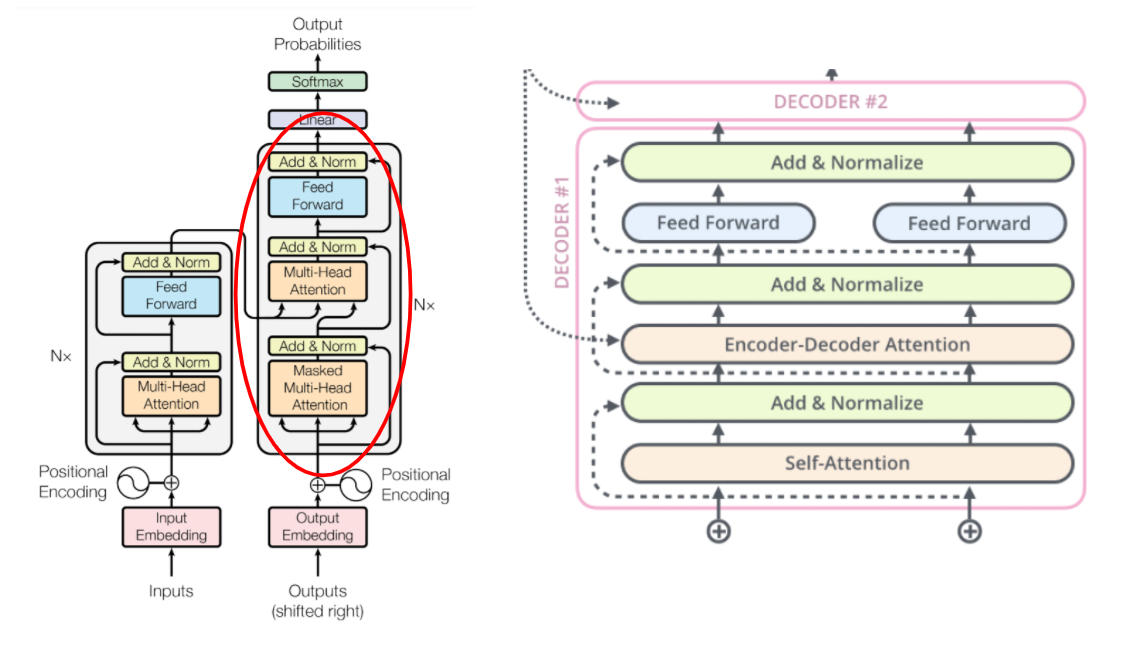

In [35]:
# 解码层（单层）
# 用于生成目标端序列
# 从模型图可以看出，解码层的输入有两部分
# 第一部分来自目标端序列（或者上一层解码层），复制为三份输入，生成目标端的QKV矩阵 (batch_size, trg_seq_len, d_model)
# 第二部分来自编码器，由编码器最后一层的输出复制为两份输入，生成源端的KV矩阵 (batch_size, src_seq_len, d_model)
# 输出 (batch_size, seq_len, d_model)
class DecoderLayer(nn.Module):
    # 从Transformer的模型图可以看出
    # DecoderLayer是由self-attention层 + src-trg attention层 + 全连接层组成的
    def __init__(self, d_model, self_attention, src_trg_attention, feed_forward, dropout=0.1):
        # self_attention 多头注意力层(第一个子层)
        # 在这层的注意力计算中，QKV矩阵均来自于目标端序列
        # src-trg attention 多头注意力层(第二个子层)
        # 在这层的注意力计算中，Q矩阵来自目标端序列，KV矩阵来自Encoder端最终的结果
        # feed_forward 全连接层(第三个子层)
        super(DecoderLayer, self).__init__()
        self.self_attention = self_attention
        self.src_trg_attention = src_trg_attention
        self.fnn = feed_forward
        self.sublayer_1 = SublayerConnectionPostLN(d_model, dropout)
        self.sublayer_2 = SublayerConnectionPostLN(d_model, dropout)
        self.sublayer_3 = SublayerConnectionPostLN(d_model, dropout)

    def forward(self, x, encoder_result, src_mask, trg_mask):
        # x (batch_size, sequence_len, d_model)
        # encoder_result (batch_size, sequence_len, d_model)
        # 来自源语言序列的Encoder之后的输出，供目标语言序列检索匹配
        print(f"input size x {x.size()}")
        print(f"input size encoder_result {encoder_result.size()}")
        print("每个 DecoderLayer 的输入 x 是 Output Embedding + Positional Encoding 的结果，或者上一层 DecoderLayer 的输出")
        print("每一层的输入 encoder_result 都是 Encoder 端最后一层的输出")
        print("在 self-attention 阶段")
        print("输入 x 被复制为三份，传入 Attention 层，分别通过W_Q、W_K、W_V参数矩阵的映射，转化为QKV矩阵")
        print("在 src-trg attention 阶段:")
        print("输入 x 和 encoder_result 被传入 Attention 层，输入 x 通过 W_Q 参数矩阵映射为 Query 矩阵，输入 encoder_result 通过 W_K、W_V 参数矩阵映射为 Key、Value 矩阵")
        x = self.sublayer_1(x, lambda x: self.self_attention(x, x, x, trg_mask))
        x = self.sublayer_2(x, lambda x: self.src_trg_attention(x, encoder_result, encoder_result, src_mask))
        # 这里就体现出 lambda 函数的作用了，因为要传入 x 之外的参数 encoder_result
        # 所以使用匿名函数的方式比较方便 
        return self.sublayer_3(x, self.fnn)

In [36]:
decoder_self_attention = MultiHeadedAttention(8, 512)
src_trg_attention = MultiHeadedAttention(8, 512)
fnn = FNN(512, 2048)
decoderlayer = DecoderLayer(512, decoder_self_attention, src_trg_attention, fnn)
decoderlayer

DecoderLayer(
  (self_attention): MultiHeadedAttention(
    (w_q): Linear(in_features=512, out_features=512, bias=True)
    (w_k): Linear(in_features=512, out_features=512, bias=True)
    (w_v): Linear(in_features=512, out_features=512, bias=True)
    (linear): Linear(in_features=512, out_features=512, bias=True)
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (src_trg_attention): MultiHeadedAttention(
    (w_q): Linear(in_features=512, out_features=512, bias=True)
    (w_k): Linear(in_features=512, out_features=512, bias=True)
    (w_v): Linear(in_features=512, out_features=512, bias=True)
    (linear): Linear(in_features=512, out_features=512, bias=True)
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (fnn): FNN(
    (w_1): Linear(in_features=512, out_features=2048, bias=True)
    (w_2): Linear(in_features=2048, out_features=512, bias=True)
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (sublayer_1): SublayerConnectionPostLN(
    (norm): LayerNormalization()
    (dropout): 

## Decoder

- Transformer 的 Decoder 由多层的 DecoderLayer 组成
- GPT 的模型结构就用的是 Transformer 的 Decoder
- GPT-1 用了12层的 Transformer DecoderLayer

In [37]:
# Decoder 编码器
# Decoder 由 N 层的 DecoderLayer 组成
# Decoder 的输入有两部分
# 第一部分来自目标端序列（或者上一层解码层），复制为三份输入，生成目标端的QKV矩阵 (batch_size, trg_seq_len, d_model)
# 第二部分来自编码器，由编码器最后一层的输出复制为两份输入，生成源端的KV矩阵 (batch_size, src_seq_len, d_model)
# 注意这里有一个细节，每一层的DecoderLayer用的都是Encoder最后一层的输出作为输入
# 输出 (batch_size, seq_len, d_model)
class Decoder(nn.Module):
    # Decoder是N个的DecoderLayer层的叠加
    def __init__(self, layer, N):
        # layer = DecoderLayer, N = 6
        super(Decoder, self).__init__()
        self.layers = clones(layer, N)

    def forward(self, x, encoder_result, src_mask, trg_mask):
        print("-----------------Decoder--------------------")
        # x (batch_size, seq_len, d_model)
        # encoder_result (batch_size, seq_len, d_model)
        # src_mask 用于屏蔽[Pad]的影响
        # trg_mask 用于屏蔽[Pad]的影响以及防止模型窥视未来信息
        for i, layer in enumerate(self.layers):
            print(f"\n------------Decoder Layer {i}---------------")
            x = layer(x, encoder_result, src_mask, trg_mask)
        print("-----------------Decoding End--------------------")
        return x

In [38]:
decoder_self_attention = MultiHeadedAttention(8, 512)
src_trg_attention = MultiHeadedAttention(8, 512)
fnn = FNN(512, 2048)
decoder = Decoder(DecoderLayer(512, decoder_self_attention, src_trg_attention, fnn), 6)
decoder

Decoder(
  (layers): ModuleList(
    (0): DecoderLayer(
      (self_attention): MultiHeadedAttention(
        (w_q): Linear(in_features=512, out_features=512, bias=True)
        (w_k): Linear(in_features=512, out_features=512, bias=True)
        (w_v): Linear(in_features=512, out_features=512, bias=True)
        (linear): Linear(in_features=512, out_features=512, bias=True)
        (dropout): Dropout(p=0.1, inplace=False)
      )
      (src_trg_attention): MultiHeadedAttention(
        (w_q): Linear(in_features=512, out_features=512, bias=True)
        (w_k): Linear(in_features=512, out_features=512, bias=True)
        (w_v): Linear(in_features=512, out_features=512, bias=True)
        (linear): Linear(in_features=512, out_features=512, bias=True)
        (dropout): Dropout(p=0.1, inplace=False)
      )
      (fnn): FNN(
        (w_1): Linear(in_features=512, out_features=2048, bias=True)
        (w_2): Linear(in_features=2048, out_features=512, bias=True)
        (dropout): Dropout(p=

# Generator (The Final Linear and Softmax Layer)

- Transformer 的最后一个模块 Generator 包含两个部分
    - 一个线性层
    - 一个softmax层
- Generator 接收 Decoder 端的输出
- 通过线性层将每个位置 d_model 维的向量映射到目标端词表大小上
- 然后通过 softmax 计算该位置是目标词表上每个词的概率
- 最终选择概率最大的作为预测词

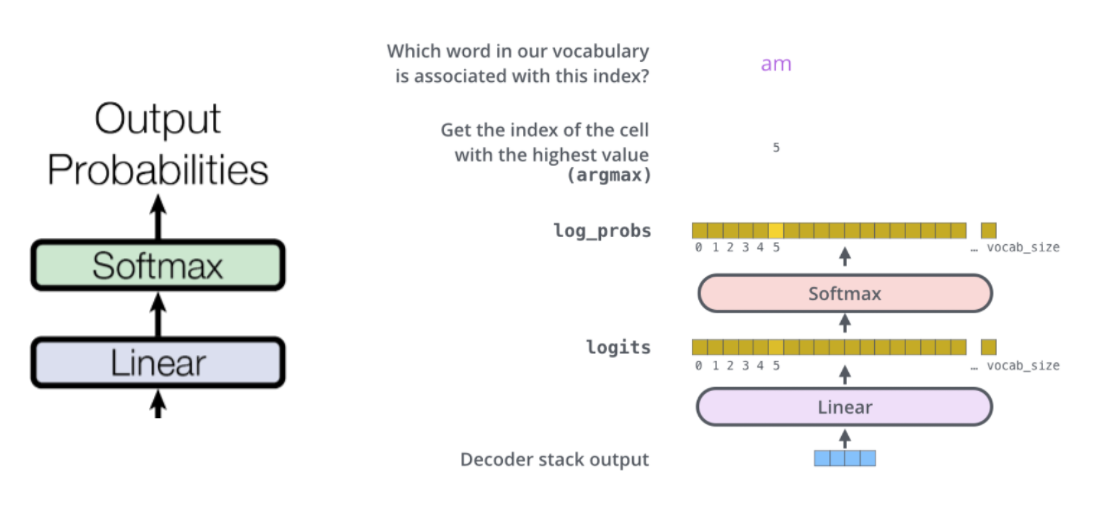

In [39]:
# Generator 生成器
# 最后生成输出序列的层
# 由一个线性层 + 一个softmax层组成
# 输入 (batch_size, seq_len, d_model)
# 输出 (batch_size, seq_len, trg_vocab_size)
class Generator(nn.Module):

    def __init__(self, d_model, trg_vocab_size):
        super(Generator, self).__init__()
        self.linear = nn.Linear(d_model, trg_vocab_size)

    def forward(self, x):
        # x (batch_size, seq_len, d_model)
        # 线性层用于将 d_model 维的表示映射到 trg_vocab_size 词表大小上
        # softmax 用于计算在词表上每个词语的概率
        return F.log_softmax(self.linear(x), dim=-1)
        # x (batch_size, sequence_len, d_model) -> linear -> (batch_size, sequence_len, trg_vocab_size)
        # 对最后一个维度计算log，然后 softmax
        # 得到(batch_size, sequence_len, trg_vocab_size)

In [40]:
generator = Generator(512, 20000)
generator

Generator(
  (linear): Linear(in_features=512, out_features=20000, bias=True)
)

# Transformer

- 到了这里，Transformer 的所有模块已经写完了，现在把她们组合成一个完整的 Transformer
- 如图所示，Transformer 分为5个部分
    - src_embedding
        - Input Embedding 层
        - Positional Encoding 位置编码层
        - 由两个层的结果相加
    - Encoder 
        - 由 N 层的 EncoderLayer 组成
        - 每层 EncoderLayer 包含
            - 一个 MultiHeadAttention 多头注意力层(self-attention)
            - Add & Norm 残差连接+层归一化
            - 一个 FNN 全连接层
            - Add & Norm 残差连接+层归一化
    - trg_embedding
        - Output Embedding 层
        - Positional Encoding 位置编码层
        - 由两个层的结果相加
    - Decoder
        - 由 N 层的 DecoderLayer 组成
        - 每层 DecoderLayer 包含
            - 一个 Masked MultiHeadAttention 多头注意力层 (self-attention)
            - Add & Norm 残差连接+层归一化
            - 一个 MultiHeadAttention 多头注意力层 (src-trg attention)
            - Add & Norm 残差连接+层归一化
            - 一个 FNN 全连接层
            - Add & Norm 残差连接+层归一化
    - Generator
        - Linear 层
        - Softmax 层

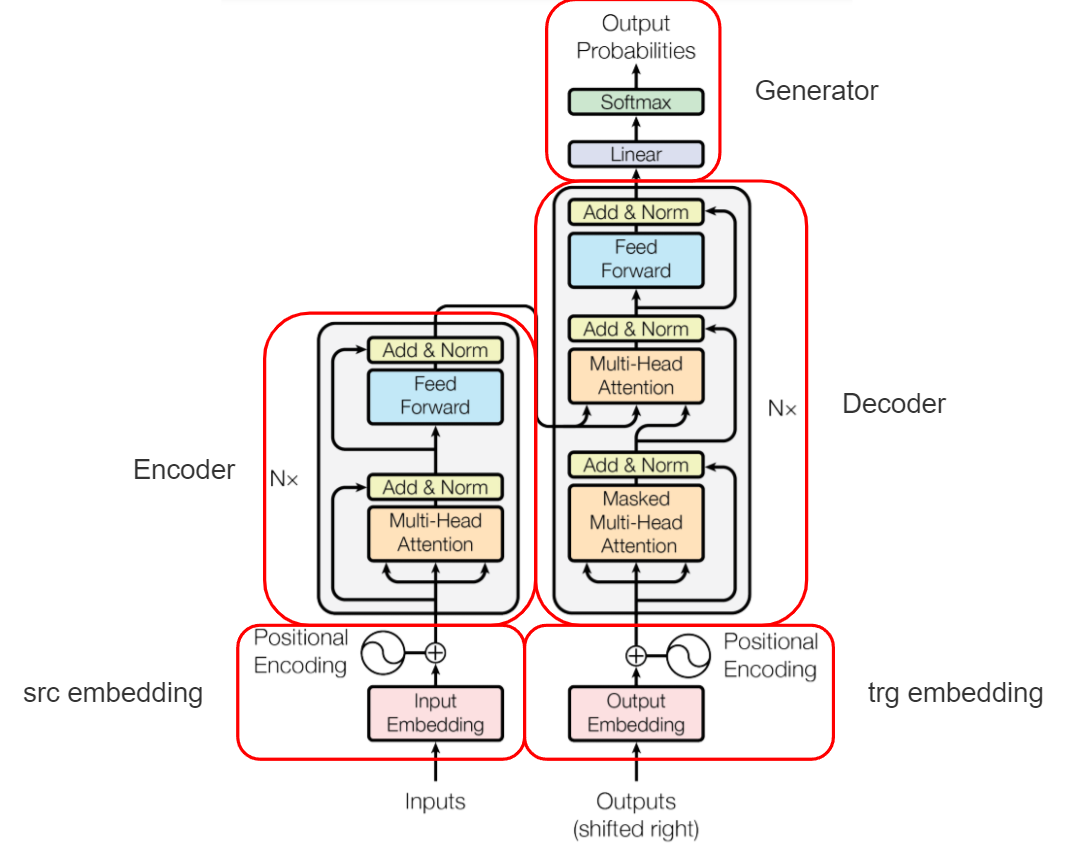

In [41]:
# 整个 Transformer 的模型架构
# 输入
# src (batch_size, seq_len) 整个batch中所有样本源端的id序列矩阵
# trg (batch_size, seq_len) 整个batch中所有样本目标端的id序列矩阵
# src_mask 源端的mask矩阵
# trg_mask 目标端的mask矩阵
# 输出
# (batch_size, seq_len, trg_vocab_size)
# 这个结果对应的是，每个句子，在该位置上，词表上各个词的概率
# 对这个结果的最后一维argmax，就能得到最终的预测结果
class Transformer(nn.Module):

    def __init__(self, src_embedding, trg_embedding, encoder, decoder, generator):
        # 整个 Transformer 包含5个模块（看图）
        # src_embedding 源端的 embedding 模块（包括词向量和位置编码两个子模块）
        # trg_embedding 目标端的 embedding 模块（包括词向量和位置编码两个子模块）
        # 源端和目标端 embedding 的输入稍有不同
        # 源端输入是整个句子 + pad mask
        # 目标端输入在训练时是整个句子  + pad mask + 上三角 mask
        # 在预测时是当前预测序列 + mask
        # encoder 是整个编码器模块，6 * Encoder layer
        # decoder 是整个解码器模块，6 * Decoder layer
        # generator 是连接在 decoder 最上层，一个全连接层 + softmax，用于生成预测结果的模块
        super(Transformer, self).__init__()
        self.src_embedding = src_embedding
        self.trg_embedding = trg_embedding
        self.encoder = encoder
        self.decoder = decoder
        self.generator = generator

    def encode(self, src, src_mask):
        # src (batch_size, seq_len)
        # 这个src就是源端的句子的id序列
        return self.encoder(self.src_embedding(src), src_mask)
        # 对源端序列进行编码
        # (batch_size, seq_len, d_model)

    def decode(self, encode_result, trg, src_mask, trg_mask):
        # encode_result Encoder 最上层输出
        # trg (batch_size, seq_len)
        # 这个trg在训练时就是目标端的句子的id序列，预测时就是已预测出来的句子的id序列
        return self.decoder(self.trg_embedding(trg), encode_result, src_mask, trg_mask)
        # 对当前已知信息 trg_embedding(trg) 和源端编码信息 encode_result，进行解码
        # (batch_size, seq_len, d_model)

    def forward(self, src, trg, src_mask, trg_mask):
        return self.decode(self.encode(src, src_mask), trg, src_mask, trg_mask)
    # 先对源端进行编码，再把结果传入目标端的解码器

In [42]:
def make_model(src_vocab_size, trg_vocab_size, N_layers=6, d_model=512, d_ff=2048, h=8, dropout=0.1):

    attention_layer = MultiHeadedAttention(h, d_model) # 8, 512
    # 构造一个多头注意力层

    fnn = FNN(d_model, d_ff, dropout)
    # 构造一个 feed forward 对象

    position = PositionalEncoding(d_model, dropout)
    # 位置编码

    model = Transformer(
        nn.Sequential(EmbeddingLayer(src_vocab_size, d_model), position),
        nn.Sequential(EmbeddingLayer(trg_vocab_size, d_model), copy.deepcopy(position)),
        Encoder(EncoderLayer(d_model, attention_layer, fnn, dropout), N_layers),
        Decoder(DecoderLayer(d_model, attention_layer, attention_layer, fnn, dropout), N_layers),
        Generator(d_model, trg_vocab_size)
    )

    # 对参数进行xavier随机初始化
    for p in model.parameters():
        if p.dim() > 1:
            nn.init.xavier_uniform_(p)

    return model

- 假设我们在进行一个机器翻译的任务
- 源端词表大小是5000，目标端词表大小是6000
- 模型参数为
    - d_model = 512
    - n_layers = 6
    - d_ff = 2048
    - n_heads = 8
- 构造模型

In [43]:
model = make_model(
    5000,
    6000,
    N_layers=6,
    d_model=512,
    d_ff=2048,
    h=8,
    dropout=0.1
)

model

Transformer(
  (src_embedding): Sequential(
    (0): EmbeddingLayer(
      (embedding): Embedding(5000, 512)
    )
    (1): PositionalEncoding(
      (dropout): Dropout(p=0.1, inplace=False)
    )
  )
  (trg_embedding): Sequential(
    (0): EmbeddingLayer(
      (embedding): Embedding(6000, 512)
    )
    (1): PositionalEncoding(
      (dropout): Dropout(p=0.1, inplace=False)
    )
  )
  (encoder): Encoder(
    (layers): ModuleList(
      (0): EncoderLayer(
        (attention): MultiHeadedAttention(
          (w_q): Linear(in_features=512, out_features=512, bias=True)
          (w_k): Linear(in_features=512, out_features=512, bias=True)
          (w_v): Linear(in_features=512, out_features=512, bias=True)
          (linear): Linear(in_features=512, out_features=512, bias=True)
          (dropout): Dropout(p=0.1, inplace=False)
        )
        (fnn): FNN(
          (w_1): Linear(in_features=512, out_features=2048, bias=True)
          (w_2): Linear(in_features=2048, out_features=512, 

- 打印模型参数

In [44]:
for name, parameters in model.named_parameters():
    print(name,':',parameters.size())

src_embedding.0.embedding.weight : torch.Size([5000, 512])
trg_embedding.0.embedding.weight : torch.Size([6000, 512])
encoder.layers.0.attention.w_q.weight : torch.Size([512, 512])
encoder.layers.0.attention.w_q.bias : torch.Size([512])
encoder.layers.0.attention.w_k.weight : torch.Size([512, 512])
encoder.layers.0.attention.w_k.bias : torch.Size([512])
encoder.layers.0.attention.w_v.weight : torch.Size([512, 512])
encoder.layers.0.attention.w_v.bias : torch.Size([512])
encoder.layers.0.attention.linear.weight : torch.Size([512, 512])
encoder.layers.0.attention.linear.bias : torch.Size([512])
encoder.layers.0.fnn.w_1.weight : torch.Size([2048, 512])
encoder.layers.0.fnn.w_1.bias : torch.Size([2048])
encoder.layers.0.fnn.w_2.weight : torch.Size([512, 2048])
encoder.layers.0.fnn.w_2.bias : torch.Size([512])
encoder.layers.0.sublayer_1.norm.a_2 : torch.Size([512])
encoder.layers.0.sublayer_1.norm.b_2 : torch.Size([512])
encoder.layers.0.sublayer_2.norm.a_2 : torch.Size([512])
encoder.laye

- 回到例子中
- 在这里为了方便展示，把各种维度按比例缩减，超参数设置如下
    - 词向量维度: d_model = 8
    - 模型内部前馈神经网络维度: d_ff = 32(8 * 4)
    - 模型的Encoder和Decoder层数: n_layers = 1
    - 使用多少个注意力头: n_heads = 2
    - Key(=Quary)向量维度: d_k = 4(8/2)
    - Value向量维度: d_v = 4(8/2)

In [45]:
model = make_model(
    data.src_vocab_size,
    data.trg_vocab_size,
    N_layers=config.n_layers,
    d_model=config.d_model,
    d_ff=config.d_ff,
    h=config.n_heads,
    dropout=0.1
)

model

Transformer(
  (src_embedding): Sequential(
    (0): EmbeddingLayer(
      (embedding): Embedding(7, 8)
    )
    (1): PositionalEncoding(
      (dropout): Dropout(p=0.1, inplace=False)
    )
  )
  (trg_embedding): Sequential(
    (0): EmbeddingLayer(
      (embedding): Embedding(9, 8)
    )
    (1): PositionalEncoding(
      (dropout): Dropout(p=0.1, inplace=False)
    )
  )
  (encoder): Encoder(
    (layers): ModuleList(
      (0): EncoderLayer(
        (attention): MultiHeadedAttention(
          (w_q): Linear(in_features=8, out_features=8, bias=True)
          (w_k): Linear(in_features=8, out_features=8, bias=True)
          (w_v): Linear(in_features=8, out_features=8, bias=True)
          (linear): Linear(in_features=8, out_features=8, bias=True)
          (dropout): Dropout(p=0.1, inplace=False)
        )
        (fnn): FNN(
          (w_1): Linear(in_features=8, out_features=32, bias=True)
          (w_2): Linear(in_features=32, out_features=8, bias=True)
          (dropout): Dr

In [46]:
for name, parameters in model.named_parameters():
    print(name,':',parameters.size())

src_embedding.0.embedding.weight : torch.Size([7, 8])
trg_embedding.0.embedding.weight : torch.Size([9, 8])
encoder.layers.0.attention.w_q.weight : torch.Size([8, 8])
encoder.layers.0.attention.w_q.bias : torch.Size([8])
encoder.layers.0.attention.w_k.weight : torch.Size([8, 8])
encoder.layers.0.attention.w_k.bias : torch.Size([8])
encoder.layers.0.attention.w_v.weight : torch.Size([8, 8])
encoder.layers.0.attention.w_v.bias : torch.Size([8])
encoder.layers.0.attention.linear.weight : torch.Size([8, 8])
encoder.layers.0.attention.linear.bias : torch.Size([8])
encoder.layers.0.fnn.w_1.weight : torch.Size([32, 8])
encoder.layers.0.fnn.w_1.bias : torch.Size([32])
encoder.layers.0.fnn.w_2.weight : torch.Size([8, 32])
encoder.layers.0.fnn.w_2.bias : torch.Size([8])
encoder.layers.0.sublayer_1.norm.a_2 : torch.Size([8])
encoder.layers.0.sublayer_1.norm.b_2 : torch.Size([8])
encoder.layers.0.sublayer_2.norm.a_2 : torch.Size([8])
encoder.layers.0.sublayer_2.norm.b_2 : torch.Size([8])
decoder.l

- 将小数据送入模型，看一下数据在模型中的流动过程

In [47]:
for batch in train_loader:
    print("\n-----------batch data---------------")
    print(batch)
    
    src_mask = (batch['input_ids'] != 0)
    src_mask = src_mask.unsqueeze(-2)
    print("\n-----------src mask---------------")
    print(src_mask)
    
    trg_mask = make_trg_mask(batch['output_ids'], 0)
    print("\n-----------trg mask---------------")
    print(trg_mask)
    
    output = model(batch["input_ids"], batch["output_ids"], src_mask, trg_mask)
    print("\nDecoding result:")
    print(f"decoding result size {output.size()}")
    print(output)


-----------batch data---------------
{'input_ids': tensor([[1, 2, 3, 4],
        [1, 5, 6, 0]]), 'output_ids': tensor([[7, 1, 2, 3, 4],
        [7, 1, 5, 6, 0]]), 'trg_ids': tensor([[1, 2, 3, 4, 8],
        [1, 5, 6, 8, 0]])}

-----------src mask---------------
tensor([[[ True,  True,  True,  True]],

        [[ True,  True,  True, False]]])

-----------trg mask---------------
tensor([[[ True, False, False, False, False],
         [ True,  True, False, False, False],
         [ True,  True,  True, False, False],
         [ True,  True,  True,  True, False],
         [ True,  True,  True,  True,  True]],

        [[ True, False, False, False, False],
         [ True,  True, False, False, False],
         [ True,  True,  True, False, False],
         [ True,  True,  True,  True, False],
         [ True,  True,  True,  True, False]]])

------------EmbeddingLayer---------------
input size torch.Size([2, 4])
output size torch.Size([2, 4, 8])
-------------------------------------------

---